In [1]:
pwd

'/mmfs1/data/aglinska/BC-actionpred-seg'

In [2]:
import os
import PIL
from PIL import Image,ImageFilter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter
import os
import shutil
import random
import cv2

/data/aglinska/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
import skvideo
import skvideo.io

def load_video(fn):
    videodata = skvideo.io.vread(fn)
    return videodata

In [4]:
def get_mask_resized_num(targ,mask):
    im2 = Image.fromarray((mask*255).astype(np.uint8)).resize(size=(targ[1],targ[0]), resample=PIL.Image.NEAREST)
    return np.array(im2)

In [5]:
def inflate_mask(mask,radius=5):
    mask_temp = Image.fromarray(mask).filter(ImageFilter.GaussianBlur(radius))
    mask_temp = np.array(mask_temp)
    mask_temp[mask_temp>0]=255
    return mask_temp

In [6]:
def plot_triple(mask1,mask2):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1);plt.imshow(mask1,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.subplot(1,3,2);plt.imshow(mask2/2,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.subplot(1,3,3);plt.imshow(mask1+mask2/2,vmin=mask1.min(),vmax=mask1.max());plt.axis('off')
    plt.tight_layout()

In [7]:
def random_jiggle_mask(all_mask,inteligent_random=True):
    min_y, min_x = np.argwhere(all_mask).min(axis=0)
    max_y, max_x = np.argwhere(all_mask).max(axis=0)
    dist_x = max_x-min_x
    dist_y = max_y-min_y
    avail_x = np.arange(0,all_mask.shape[1]-dist_x)
    avail_y = np.arange(0,all_mask.shape[0]-dist_y)
    
    #inteligent_random = True
    if inteligent_random==True:
        prob_x = np.ones(len(avail_x))
        prob_x[((avail_x>=min_x-dist_x)*(avail_x<=max_x))]=.001

        prob_y = np.ones(len(avail_y))
        prob_y[((avail_y>=min_y)*(avail_y<=max_y))]=.001

        choose_x = random.choices(avail_x,weights=prob_x,k=1)[0]
        choose_y = random.choices(avail_y,weights=prob_y,k=1)[0]
    else:        
        choose_x = random.choice(avail_x)
        choose_y = random.choice(avail_y)
    
    e_mask = np.zeros(all_mask.shape)
    blob = all_mask[min_y:max_y,min_x:max_x]
    e_mask[choose_y:choose_y+dist_y,choose_x:choose_x+dist_x] = blob
    return e_mask.astype(np.uint8)

In [8]:
indir = '~/BC-actionpred-seg/Data/haa500_v1_1_yolo_seg4'
indir = os.path.expanduser(indir)
indir

'/data/aglinska/BC-actionpred-seg/Data/haa500_v1_1_yolo_seg4'

In [9]:
folders = [folder for folder in os.listdir(indir) if not folder.startswith('.')]
folders.sort()
n = len(folders)
print(n)
folders[0:3]

499


['ALS_IceBucket_Challenge', 'CPR', 'abseiling']

In [10]:
fn_temp = '{indir}/{folder}/{folder}_{video}_item_0_masks.npy'

(20, 499)
(0.8550100200400802, 8533)


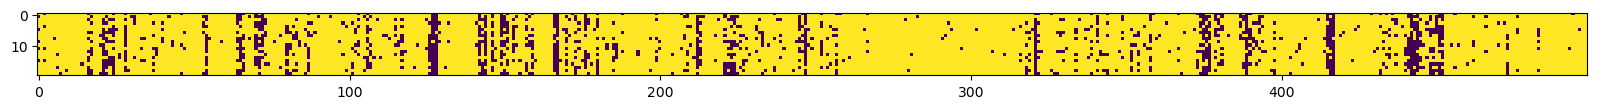

In [11]:
#good_videos = np.load('good_videos.npy')
good_videos = np.load('good_videos_1p.npy')
print(good_videos.shape)
print((good_videos.mean(),good_videos.sum()))
plt.figure(figsize=np.array((10,5))*2)
plt.imshow(good_videos)

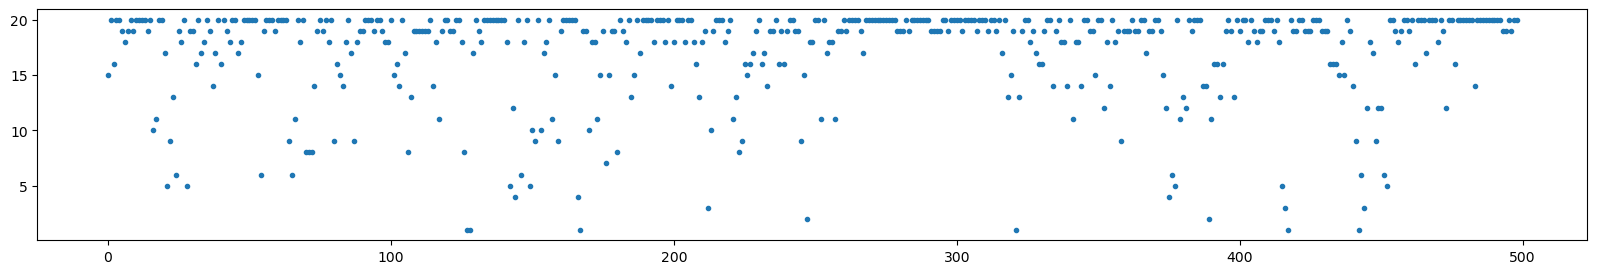

In [12]:
plt.figure(figsize=np.array((20,3)))
plt.plot(good_videos.sum(axis=0),'.')

In [13]:
good_videos[:,good_videos.sum(axis=0)<20] = False

In [14]:
# good_videos[:,good_videos.sum(axis=0)<15] = False
# good_videos[15:20,:] = False

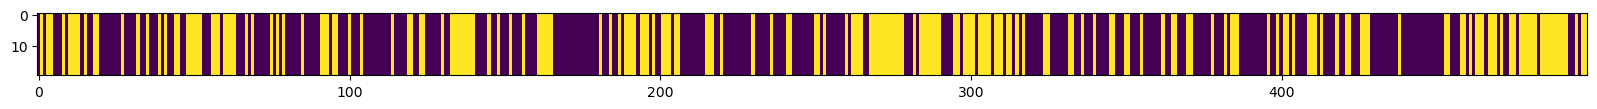

In [15]:
plt.figure(figsize=np.array((10,5))*2)
plt.imshow(good_videos)

In [16]:
print(good_videos.mean(),good_videos.sum())

0.40681362725450904 4060


In [17]:
calc_or_load = 'None'

if calc_or_load=='calc':
    
    fn_temp = '{indir}/{folder}/{folder}_{video}_item_0_masks.npy'
    pad_fn_temp = './Data/haa500_v1_1_resized/video/{folder}/{folder}_{video}_padding.npy'
    masks2 = np.zeros((20,499,360,640))*np.nan
    for f in tqdm(range(good_videos.shape[1])):
        for v in range(good_videos.shape[0]):
            if bool(good_videos[v,f])==True:
                fn = fn_temp.format(indir=indir,folder=folders[f],video=f'{v:03d}')

                mask = np.load(fn)
                mask = inflate_mask((( mask.sum(axis=0) >0 )*255).astype(np.uint8),radius=15)
                mask = get_mask_resized_num((360, 640),mask)


                pad_fn = pad_fn_temp.format(folder=folders[f],video=f'{v:03d}')
                pad = np.load(pad_fn)
                pad = (pad==0)*1

                masks2[v,f,:,:] = mask+pad
                
    np.savez_compressed('./Data/masks2.npz',arr=masks2)
    
elif calc_or_load=='load':        
    masks2 = np.load('./Data/masks2.npz')['arr']
    print(masks2.shape)

In [18]:
#masks2.shape

In [19]:
#plt.hist((masks2==0).sum(axis=-1).sum(axis=-1).mean(axis=0))

In [20]:
#msize = (masks2==0).sum(axis=-1).sum(axis=-1).mean(axis=0)

In [21]:
#( (msize > 0) * (msize < np.sort(msize[msize>0])[100]) ).sum()

In [22]:
#good_videos[:,msize > np.sort(msize[msize>0])[99]] = False
#print(good_videos[1,:].sum())
#np.save('./Data/good_videos_small.npy',good_videos)

In [23]:
good_videos = np.load('./Data/good_videos_small.npy')

100


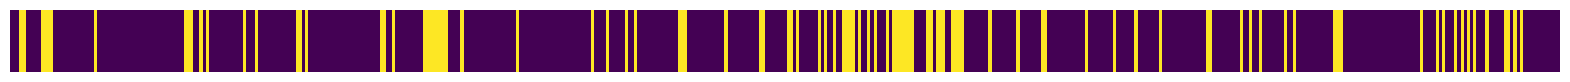

In [24]:
plt.figure(figsize=np.array((10,5))*2);
plt.imshow(good_videos);
plt.axis('off')
print(good_videos[0,:].sum());

In [25]:
###

calc_or_load = 'load'

if calc_or_load=='calc':

    fn_temp = '{indir}/{folder}/{folder}_{video}_item_0_masks.npy'
    pad_fn_temp = './Data/haa500_v1_1_resized/video/{folder}/{folder}_{video}_padding.npy'

    fns = []
    masks = []
    paddings = []

    for f in tqdm(range(good_videos.shape[1])):
        for v in range(good_videos.shape[0]):
            if bool(good_videos[v,f])==True:
                fn = fn_temp.format(indir=indir,folder=folders[f],video=f'{v:03d}')

                mask = np.load(fn)
                mask = inflate_mask((( mask.sum(axis=0) >0 )*255).astype(np.uint8),radius=15)
                mask = get_mask_resized_num((360, 640),mask)


                pad_fn = pad_fn_temp.format(folder=folders[f],video=f'{v:03d}')
                pad = np.load(pad_fn)

                fns.append(fn)
                masks.append(mask)
                paddings.append(pad)
                

    masks = np.array(masks)
    fns = np.array(fns)
    paddings = (np.array(paddings)==0)*1
    
    np.savez_compressed('./Data/data_good_videos_1p_masks_small.npz',arr=masks)
    np.savez_compressed('./Data/data_good_videos_1p_fns_small.npz',arr=fns)
    np.savez_compressed('./Data/data_good_videos_1p_paddings_small.npz',arr=paddings)
    
elif calc_or_load=='load':
    
    masks = np.load('./Data/data_good_videos_1p_masks_small.npz')['arr']
    fns = np.load('./Data/data_good_videos_1p_fns_small.npz')['arr']
    paddings = np.load('./Data/data_good_videos_1p_paddings_small.npz')['arr']
    
    print(masks.shape)
    print(fns.shape)
    print(paddings.shape)

(2000, 360, 640)
(2000,)
(2000, 360, 640)


In [26]:
masks.shape

(2000, 360, 640)

In [27]:
paddings.shape

(2000, 360, 640)

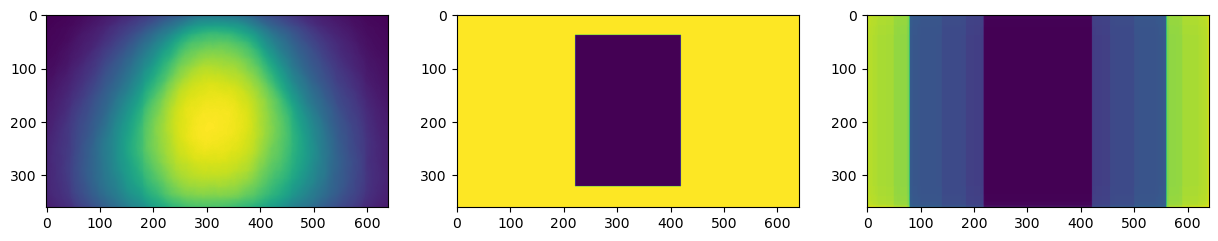

In [28]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1);plt.imshow(masks.mean(axis=0))
plt.subplot(1,3,2);plt.imshow(paddings.max(axis=0))
plt.subplot(1,3,3);plt.imshow(paddings.mean(axis=0))
#plt.show()

0.49023153428819444


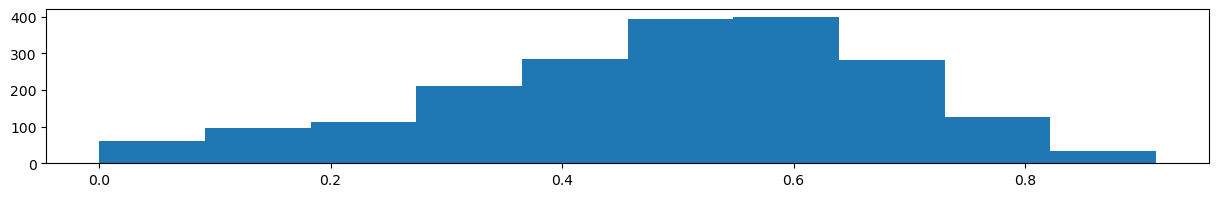

In [29]:
perc = [((masks[i,:,:]+paddings[i,:,:])==0).sum() / (360*640) for i in range(masks.shape[0])];
print(np.array(perc).mean());
plt.figure(figsize=(15,2));
plt.hist(perc);

In [30]:
n = masks.shape[0]
filled_spots = np.repeat(False,n)
spots_found_for = np.repeat(False,n)
where_to_inpaint_idx = np.zeros(n)
masks_to_inpaint = np.zeros(masks.shape) # To keep the jiggled masks 

In [31]:
calc_or_load_inpaint_idx = 'calc'

if calc_or_load_inpaint_idx == 'calc':
    
    n = masks.shape[0]
    filled_spots = np.repeat(False,n)
    spots_found_for = np.repeat(False,n)
    where_to_inpaint_idx = np.zeros(n)
    masks_to_inpaint = np.zeros(masks.shape) # To keep the jiggled masks 

    plt.ioff()
    for i in tqdm(range(n)):
        this_mask = masks[i,:,:] # grab a mask
        
        for rr in range(50): #V2.0 jiggle a hundo times
            this_mask = random_jiggle_mask(this_mask,inteligent_random=False) # V2.0 Jiggle the mask 

            ## N.B if comp is <1.0 or <255
            where_fits = np.array( [(  this_mask.astype(float)+masks[j,:,:].astype(float)+paddings[j,:,:].astype(float)   ).max()   <=1.0 for j in range(n)] ) # Teh l33t alg0
            where_fits[filled_spots] = False # Make sure not already filles

            if where_fits.sum()>0:
                #print('triggered')
                where_fits_idx = np.nonzero(where_fits)[0]
                temp = np.argsort([    ((this_mask.astype(float)+masks[j,:,:].astype(float)+paddings[j,:,:].astype(float))==0).sum()       for j in where_fits_idx])[0]
                where_fits_choose = where_fits_idx[temp]

                # Bookkeeping
                filled_spots[where_fits_choose] = True
                spots_found_for[i]=True
                where_to_inpaint_idx[i] = where_fits_choose
                masks_to_inpaint[i,:,:] = this_mask # V2.0

                plot_triple(this_mask,masks[where_fits_choose,:,:]+paddings[where_fits_choose,:,:])
                plt.savefig(f'./Data/inpaint-triplet-figs-small/{i:04d}.png')
                plt.close()
                
                break # If found a spot, break out of the for loop
                
            if np.mod(i,250)==0:
                np.savez_compressed('./Data/data_inpainting_idx_filled_spots_small.npz',arr=filled_spots)
                np.savez_compressed('./Data/data_inpainting_idx_spots_found_for_small.npz',arr=spots_found_for)
                np.savez_compressed('./Data/data_inpainting_idx_where_to_inpaint_idx_small.npz',arr=where_to_inpaint_idx)
                np.savez_compressed('./Data/data_inpainting_idx_masks_to_inpain_small.npz',arr=masks_to_inpaint)

    print('saving')
    
    np.savez_compressed('./Data/data_inpainting_idx_filled_spots_small.npz',arr=filled_spots)
    np.savez_compressed('./Data/data_inpainting_idx_spots_found_for_small.npz',arr=spots_found_for)
    np.savez_compressed('./Data/data_inpainting_idx_where_to_inpaint_idx_small.npz',arr=where_to_inpaint_idx)
    np.savez_compressed('./Data/data_inpainting_idx_masks_to_inpain_small.npz',arr=masks_to_inpaint)
    print('done')
    
elif calc_or_load_inpaint_idx == 'load':

    filled_spots = np.load('./Data/data_inpainting_idx_filled_spots_small.npz')['arr']
    spots_found_for = np.load('./Data/data_inpainting_idx_spots_found_for_small.npz')['arr']
    where_to_inpaint_idx = np.load('./Data/data_inpainting_idx_where_to_inpaint_idx_small.npz')['arr']
    masks_to_inpain = np.load('./Data/data_inpainting_idx_masks_to_inpain_small.npz')['arr']

    
elif calc_or_load_inpaint_idx == 'continue':
    
    n = masks.shape[0]
    filled_spots = np.load('./Data/data_inpainting_idx_filled_spots_small.npz')['arr']
    spots_found_for = np.load('./Data/data_inpainting_idx_spots_found_for_small.npz')['arr']
    where_to_inpaint_idx = np.load('./Data/data_inpainting_idx_where_to_inpaint_idx_small.npz')['arr']
    masks_to_inpaint = np.load('./Data/data_inpainting_idx_masks_to_inpain_small.npz')['arr']
    start_point = spots_found_for.nonzero()[0].max()
    
    plt.ioff()
    for i in tqdm(range(start_point,n)):
        this_mask = masks[i,:,:] # grab a mask
        
        for rr in range(50): #V2.0 jiggle a hundo times
            this_mask = random_jiggle_mask(this_mask,inteligent_random=False) # V2.0 Jiggle the mask 

            ## N.B if comp is <1.0 or <255
            where_fits = np.array( [(  this_mask.astype(float)+masks[j,:,:].astype(float)+paddings[j,:,:].astype(float)   ).max()   <=1.0 for j in range(n)] ) # Teh l33t alg0
            where_fits[filled_spots] = False # Make sure not already filles

            if where_fits.sum()>0:
                #print('triggered')
                where_fits_idx = np.nonzero(where_fits)[0]
                temp = np.argsort([    ((this_mask.astype(float)+masks[j,:,:].astype(float)+paddings[j,:,:].astype(float))==0).sum()       for j in where_fits_idx])[0]
                where_fits_choose = where_fits_idx[temp]

                # Bookkeeping
                filled_spots[where_fits_choose] = True
                spots_found_for[i]=True
                where_to_inpaint_idx[i] = where_fits_choose
                masks_to_inpaint[i,:,:] = this_mask # V2.0

                plot_triple(this_mask,masks[where_fits_choose,:,:]+paddings[where_fits_choose,:,:])
                plt.savefig(f'./Data/inpaint-triplet-figs-small/{i:04d}.png')
                plt.close()
                
                break # If found a spot, break out of the for loop
                
        if np.mod(i,500)==0:
            np.savez_compressed('./Data/data_inpainting_idx_filled_spots_small.npz',arr=filled_spots)
            np.savez_compressed('./Data/data_inpainting_idx_spots_found_for_small.npz',arr=spots_found_for)
            np.savez_compressed('./Data/data_inpainting_idx_where_to_inpaint_idx_small.npz',arr=where_to_inpaint_idx)
            np.savez_compressed('./Data/data_inpainting_idx_masks_to_inpain_small.npz',arr=masks_to_inpaint)

    print('saving')
    #np.savez_compressed('./Data/data_inpainting_idx.npz',filled_spots=filled_spots,spots_found_for=spots_found_for,where_to_inpaint_idx=where_to_inpaint_idx,masks_to_inpain=masks_to_inpaint)
    np.savez_compressed('./Data/data_inpainting_idx_filled_spots_small.npz',arr=filled_spots)
    np.savez_compressed('./Data/data_inpainting_idx_spots_found_for_small.npz',arr=spots_found_for)
    np.savez_compressed('./Data/data_inpainting_idx_where_to_inpaint_idx_small.npz',arr=where_to_inpaint_idx)
    np.savez_compressed('./Data/data_inpainting_idx_masks_to_inpain_small.npz',arr=masks_to_inpaint)
    print('done')

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 1/2000 [00:02<1:21:13,  2.44s/it]

  0%|          | 2/2000 [00:04<1:21:05,  2.44s/it]

  0%|          | 3/2000 [00:07<1:21:29,  2.45s/it]

  0%|          | 4/2000 [00:20<3:47:13,  6.83s/it]

  0%|          | 5/2000 [00:23<2:53:33,  5.22s/it]

  0%|          | 6/2000 [02:08<21:44:04, 39.24s/it]

  0%|          | 7/2000 [02:10<15:01:42, 27.15s/it]

  0%|          | 8/2000 [02:13<10:37:58, 19.22s/it]

  0%|          | 9/2000 [02:23<9:07:14, 16.49s/it] 

  0%|          | 10/2000 [02:25<6:40:58, 12.09s/it]

  1%|          | 11/2000 [02:27<5:00:47,  9.07s/it]

  1%|          | 12/2000 [02:30<3:51:44,  6.99s/it]

  1%|          | 13/2000 [02:32<3:03:56,  5.55s/it]

  1%|          | 14/2000 [04:10<18:28:07, 33.48s/it]

  1%|          | 15/2000 [05:47<29:03:19, 52.69s/it]

  1%|          | 16/2000 [05:49<20:38:48, 37.46s/it]

  1%|          | 17/2000 [07:23<30:01:17, 54.50s/it]

  1%|          | 18/2000 [07:25<21:19:39, 38.74s/it]

  1%|          | 19/2000 [07:27<15:15:01, 27.71s/it]

  1%|          | 20/2000 [07:30<11:00:36, 20.02s/it]

  1%|          | 21/2000 [07:35<8:39:06, 15.74s/it] 

  1%|          | 22/2000 [09:10<21:40:51, 39.46s/it]

  1%|          | 23/2000 [09:13<15:35:10, 28.38s/it]

  1%|          | 24/2000 [10:49<26:46:31, 48.78s/it]

  1%|▏         | 25/2000 [12:27<34:48:17, 63.44s/it]

  1%|▏         | 26/2000 [14:04<40:25:55, 73.74s/it]

  1%|▏         | 27/2000 [15:09<38:51:21, 70.90s/it]

  1%|▏         | 28/2000 [16:07<36:49:46, 67.23s/it]

  1%|▏         | 29/2000 [17:48<42:16:32, 77.22s/it]

  2%|▏         | 30/2000 [18:12<33:36:51, 61.43s/it]

  2%|▏         | 31/2000 [19:52<39:51:27, 72.87s/it]

  2%|▏         | 32/2000 [21:30<43:59:31, 80.47s/it]

  2%|▏         | 33/2000 [23:11<47:13:14, 86.42s/it]

  2%|▏         | 34/2000 [24:28<45:42:44, 83.71s/it]

  2%|▏         | 35/2000 [26:14<49:25:45, 90.56s/it]

  2%|▏         | 36/2000 [26:58<41:46:05, 76.56s/it]

  2%|▏         | 37/2000 [27:06<30:25:06, 55.79s/it]

  2%|▏         | 38/2000 [28:46<37:44:21, 69.25s/it]

  2%|▏         | 39/2000 [29:00<28:41:37, 52.68s/it]

  2%|▏         | 40/2000 [29:08<21:23:10, 39.28s/it]

  2%|▏         | 41/2000 [30:49<31:25:22, 57.75s/it]

  2%|▏         | 42/2000 [32:05<34:18:35, 63.08s/it]

  2%|▏         | 43/2000 [32:19<26:20:06, 48.44s/it]

  2%|▏         | 44/2000 [32:27<19:45:28, 36.36s/it]

  2%|▏         | 45/2000 [34:07<30:04:30, 55.38s/it]

  2%|▏         | 46/2000 [35:17<32:30:18, 59.89s/it]

  2%|▏         | 47/2000 [35:28<24:30:24, 45.17s/it]

  2%|▏         | 48/2000 [35:39<18:56:33, 34.94s/it]

  2%|▏         | 49/2000 [36:45<23:52:48, 44.06s/it]

  2%|▎         | 50/2000 [38:29<33:41:14, 62.19s/it]

  3%|▎         | 51/2000 [38:54<27:39:14, 51.08s/it]

  3%|▎         | 52/2000 [40:31<35:02:38, 64.76s/it]

  3%|▎         | 53/2000 [40:47<27:03:44, 50.04s/it]

  3%|▎         | 54/2000 [40:56<20:31:07, 37.96s/it]

  3%|▎         | 55/2000 [41:10<16:35:17, 30.70s/it]

  3%|▎         | 56/2000 [41:31<15:01:27, 27.82s/it]

  3%|▎         | 57/2000 [43:08<26:08:10, 48.43s/it]

  3%|▎         | 58/2000 [44:46<34:06:30, 63.23s/it]

  3%|▎         | 59/2000 [46:25<39:59:43, 74.18s/it]

  3%|▎         | 60/2000 [46:43<30:49:53, 57.21s/it]

  3%|▎         | 61/2000 [48:22<37:32:07, 69.69s/it]

  3%|▎         | 62/2000 [48:33<28:06:25, 52.21s/it]

  3%|▎         | 63/2000 [48:42<21:01:35, 39.08s/it]

  3%|▎         | 64/2000 [50:21<30:45:19, 57.19s/it]

  3%|▎         | 65/2000 [50:46<25:33:27, 47.55s/it]

  3%|▎         | 66/2000 [52:23<33:28:42, 62.32s/it]

  3%|▎         | 67/2000 [52:34<25:15:37, 47.04s/it]

  3%|▎         | 68/2000 [54:12<33:20:34, 62.13s/it]

  3%|▎         | 69/2000 [55:48<38:45:48, 72.27s/it]

  4%|▎         | 70/2000 [55:56<28:32:36, 53.24s/it]

  4%|▎         | 71/2000 [56:05<21:21:28, 39.86s/it]

  4%|▎         | 72/2000 [56:17<16:55:55, 31.62s/it]

  4%|▎         | 73/2000 [56:25<13:08:11, 24.54s/it]

  4%|▎         | 74/2000 [58:00<24:17:51, 45.42s/it]

  4%|▍         | 75/2000 [59:30<31:26:49, 58.81s/it]

  4%|▍         | 76/2000 [1:01:00<36:30:12, 68.30s/it]

  4%|▍         | 77/2000 [1:02:23<38:54:49, 72.85s/it]

  4%|▍         | 78/2000 [1:02:31<28:28:02, 53.32s/it]

  4%|▍         | 79/2000 [1:04:04<34:44:12, 65.10s/it]

  4%|▍         | 80/2000 [1:04:13<25:42:48, 48.21s/it]

  4%|▍         | 81/2000 [1:04:21<19:19:31, 36.25s/it]

  4%|▍         | 82/2000 [1:04:35<15:47:23, 29.64s/it]

  4%|▍         | 83/2000 [1:05:30<19:51:56, 37.31s/it]

  4%|▍         | 84/2000 [1:07:06<29:12:52, 54.89s/it]

  4%|▍         | 85/2000 [1:08:42<35:38:44, 67.01s/it]

  4%|▍         | 86/2000 [1:10:13<39:27:38, 74.22s/it]

  4%|▍         | 87/2000 [1:10:21<28:52:03, 54.33s/it]

  4%|▍         | 88/2000 [1:11:56<35:24:09, 66.66s/it]

  4%|▍         | 89/2000 [1:13:32<39:59:51, 75.35s/it]

  4%|▍         | 90/2000 [1:15:07<43:13:19, 81.47s/it]

  5%|▍         | 91/2000 [1:16:46<45:58:45, 86.71s/it]

  5%|▍         | 92/2000 [1:17:53<42:50:20, 80.83s/it]

  5%|▍         | 93/2000 [1:19:29<45:11:15, 85.30s/it]

  5%|▍         | 94/2000 [1:19:31<31:57:40, 60.37s/it]

  5%|▍         | 95/2000 [1:19:44<24:18:04, 45.92s/it]

  5%|▍         | 96/2000 [1:19:53<18:30:40, 35.00s/it]

  5%|▍         | 97/2000 [1:20:02<14:25:21, 27.28s/it]

  5%|▍         | 98/2000 [1:21:39<25:26:28, 48.15s/it]

  5%|▍         | 99/2000 [1:23:17<33:14:13, 62.94s/it]

  5%|▌         | 100/2000 [1:23:19<23:36:03, 44.72s/it]

  5%|▌         | 101/2000 [1:23:22<16:59:51, 32.22s/it]

  5%|▌         | 102/2000 [1:24:59<27:19:40, 51.83s/it]

  5%|▌         | 103/2000 [1:26:37<34:34:30, 65.61s/it]

  5%|▌         | 104/2000 [1:28:13<39:20:57, 74.71s/it]

  5%|▌         | 105/2000 [1:29:50<42:44:26, 81.20s/it]

  5%|▌         | 106/2000 [1:30:46<38:47:01, 73.72s/it]

  5%|▌         | 107/2000 [1:32:19<41:48:09, 79.50s/it]

  5%|▌         | 108/2000 [1:33:47<43:05:19, 81.99s/it]

  5%|▌         | 109/2000 [1:33:50<30:44:51, 58.54s/it]

  6%|▌         | 110/2000 [1:34:39<29:12:28, 55.63s/it]

  6%|▌         | 111/2000 [1:36:11<34:57:12, 66.61s/it]

  6%|▌         | 112/2000 [1:37:46<39:14:53, 74.84s/it]

  6%|▌         | 113/2000 [1:39:02<39:30:55, 75.39s/it]

  6%|▌         | 114/2000 [1:40:35<42:16:15, 80.69s/it]

  6%|▌         | 115/2000 [1:41:20<36:32:53, 69.80s/it]

  6%|▌         | 116/2000 [1:41:27<26:45:14, 51.12s/it]

  6%|▌         | 117/2000 [1:43:03<33:45:22, 64.54s/it]

  6%|▌         | 118/2000 [1:44:37<38:17:55, 73.26s/it]

  6%|▌         | 119/2000 [1:45:54<38:52:14, 74.39s/it]

  6%|▌         | 120/2000 [1:47:29<42:11:20, 80.79s/it]

  6%|▌         | 121/2000 [1:47:40<31:07:40, 59.64s/it]

  6%|▌         | 122/2000 [1:49:17<37:02:36, 71.01s/it]

  6%|▌         | 123/2000 [1:49:30<27:55:35, 53.56s/it]

  6%|▌         | 124/2000 [1:49:32<19:53:14, 38.16s/it]

  6%|▋         | 125/2000 [1:51:10<29:15:04, 56.16s/it]

  6%|▋         | 126/2000 [1:52:50<36:00:08, 69.16s/it]

  6%|▋         | 127/2000 [1:54:30<40:45:09, 78.33s/it]

  6%|▋         | 128/2000 [1:54:41<30:12:11, 58.08s/it]

  6%|▋         | 129/2000 [1:56:21<36:50:36, 70.89s/it]

  6%|▋         | 130/2000 [1:56:34<27:49:07, 53.55s/it]

  7%|▋         | 131/2000 [1:56:43<20:49:28, 40.11s/it]

  7%|▋         | 132/2000 [1:56:54<16:11:29, 31.20s/it]

  7%|▋         | 133/2000 [1:58:35<27:07:45, 52.31s/it]

  7%|▋         | 134/2000 [1:58:49<21:12:09, 40.91s/it]

  7%|▋         | 135/2000 [1:59:04<17:06:43, 33.03s/it]

  7%|▋         | 136/2000 [2:00:44<27:34:08, 53.24s/it]

  7%|▋         | 137/2000 [2:02:26<35:05:04, 67.80s/it]

  7%|▋         | 138/2000 [2:03:44<36:38:36, 70.85s/it]

  7%|▋         | 139/2000 [2:03:53<26:58:28, 52.18s/it]

  7%|▋         | 140/2000 [2:04:01<20:12:26, 39.11s/it]

  7%|▋         | 141/2000 [2:04:10<15:26:24, 29.90s/it]

  7%|▋         | 142/2000 [2:05:52<26:33:01, 51.44s/it]

  7%|▋         | 143/2000 [2:07:30<33:51:59, 65.65s/it]

  7%|▋         | 144/2000 [2:07:44<25:52:04, 50.17s/it]

  7%|▋         | 145/2000 [2:09:23<33:16:50, 64.59s/it]

  7%|▋         | 146/2000 [2:09:40<26:01:32, 50.54s/it]

  7%|▋         | 147/2000 [2:09:48<19:27:14, 37.80s/it]

  7%|▋         | 148/2000 [2:10:39<21:26:10, 41.67s/it]

  7%|▋         | 149/2000 [2:10:59<18:05:03, 35.17s/it]

  8%|▊         | 150/2000 [2:11:47<20:05:35, 39.10s/it]

  8%|▊         | 151/2000 [2:13:28<29:33:15, 57.54s/it]

  8%|▊         | 152/2000 [2:15:11<36:28:50, 71.07s/it]

  8%|▊         | 153/2000 [2:16:35<38:34:24, 75.18s/it]

  8%|▊         | 154/2000 [2:16:42<28:03:45, 54.73s/it]

  8%|▊         | 155/2000 [2:17:03<22:50:44, 44.58s/it]

  8%|▊         | 156/2000 [2:17:17<18:01:14, 35.18s/it]

  8%|▊         | 157/2000 [2:17:24<13:41:25, 26.74s/it]

  8%|▊         | 158/2000 [2:18:13<17:09:38, 33.54s/it]

  8%|▊         | 159/2000 [2:19:38<25:06:01, 49.08s/it]

  8%|▊         | 160/2000 [2:21:20<33:09:28, 64.87s/it]

  8%|▊         | 161/2000 [2:22:58<38:14:37, 74.87s/it]

  8%|▊         | 162/2000 [2:24:36<41:43:36, 81.73s/it]

  8%|▊         | 163/2000 [2:26:15<44:19:16, 86.86s/it]

  8%|▊         | 164/2000 [2:27:52<45:56:52, 90.09s/it]

  8%|▊         | 165/2000 [2:29:29<46:50:54, 91.91s/it]

  8%|▊         | 166/2000 [2:31:04<47:21:56, 92.98s/it]

  8%|▊         | 167/2000 [2:32:42<48:08:56, 94.56s/it]

  8%|▊         | 168/2000 [2:34:18<48:20:08, 94.98s/it]

  8%|▊         | 169/2000 [2:34:32<35:50:47, 70.48s/it]

  8%|▊         | 170/2000 [2:36:08<39:44:43, 78.19s/it]

  9%|▊         | 171/2000 [2:37:45<42:37:29, 83.90s/it]

  9%|▊         | 172/2000 [2:39:24<44:52:11, 88.37s/it]

  9%|▊         | 173/2000 [2:41:03<46:27:01, 91.53s/it]

  9%|▊         | 174/2000 [2:42:41<47:27:45, 93.57s/it]

  9%|▉         | 175/2000 [2:44:15<47:33:47, 93.82s/it]

  9%|▉         | 176/2000 [2:45:49<47:33:23, 93.86s/it]

  9%|▉         | 177/2000 [2:47:25<47:48:43, 94.42s/it]

  9%|▉         | 178/2000 [2:49:00<47:52:27, 94.59s/it]

  9%|▉         | 179/2000 [2:50:35<47:53:53, 94.69s/it]

  9%|▉         | 180/2000 [2:50:57<36:53:39, 72.98s/it]

  9%|▉         | 181/2000 [2:51:09<27:31:00, 54.46s/it]

  9%|▉         | 182/2000 [2:51:48<25:08:44, 49.79s/it]

  9%|▉         | 183/2000 [2:52:42<25:53:49, 51.31s/it]

  9%|▉         | 184/2000 [2:54:20<32:55:48, 65.28s/it]

  9%|▉         | 185/2000 [2:55:57<37:40:21, 74.72s/it]

  9%|▉         | 186/2000 [2:57:34<40:56:55, 81.27s/it]

  9%|▉         | 187/2000 [2:57:44<30:13:35, 60.02s/it]

  9%|▉         | 188/2000 [2:58:29<28:00:21, 55.64s/it]

  9%|▉         | 189/2000 [3:00:02<33:29:28, 66.58s/it]

 10%|▉         | 190/2000 [3:00:39<29:06:27, 57.89s/it]

 10%|▉         | 191/2000 [3:02:12<34:24:55, 68.49s/it]

 10%|▉         | 192/2000 [3:02:58<30:52:56, 61.49s/it]

 10%|▉         | 193/2000 [3:03:07<22:58:12, 45.76s/it]

 10%|▉         | 194/2000 [3:04:42<30:25:12, 60.64s/it]

 10%|▉         | 195/2000 [3:05:05<24:46:32, 49.41s/it]

 10%|▉         | 196/2000 [3:06:44<32:09:35, 64.18s/it]

 10%|▉         | 197/2000 [3:08:19<36:45:49, 73.41s/it]

 10%|▉         | 198/2000 [3:08:42<29:15:40, 58.46s/it]

 10%|▉         | 199/2000 [3:09:01<23:14:36, 46.46s/it]

 10%|█         | 200/2000 [3:09:08<17:16:34, 34.55s/it]

 10%|█         | 201/2000 [3:09:21<14:04:31, 28.17s/it]

 10%|█         | 202/2000 [3:11:01<24:50:37, 49.74s/it]

 10%|█         | 203/2000 [3:12:01<26:21:49, 52.82s/it]

 10%|█         | 204/2000 [3:12:38<24:00:31, 48.12s/it]

 10%|█         | 205/2000 [3:14:14<31:11:27, 62.56s/it]

 10%|█         | 206/2000 [3:14:22<22:54:56, 45.98s/it]

 10%|█         | 207/2000 [3:15:45<28:26:27, 57.10s/it]

 10%|█         | 208/2000 [3:15:50<20:44:20, 41.66s/it]

 10%|█         | 209/2000 [3:17:20<27:53:20, 56.06s/it]

 10%|█         | 210/2000 [3:18:47<32:32:00, 65.43s/it]

 11%|█         | 211/2000 [3:20:17<36:04:54, 72.61s/it]

 11%|█         | 212/2000 [3:21:49<38:58:51, 78.49s/it]

 11%|█         | 213/2000 [3:23:19<40:45:37, 82.11s/it]

 11%|█         | 214/2000 [3:24:24<38:11:29, 76.98s/it]

 11%|█         | 215/2000 [3:24:34<28:06:34, 56.69s/it]

 11%|█         | 216/2000 [3:25:48<30:38:19, 61.83s/it]

 11%|█         | 217/2000 [3:26:00<23:18:29, 47.06s/it]

 11%|█         | 218/2000 [3:27:30<29:40:57, 59.96s/it]

 11%|█         | 219/2000 [3:27:38<21:51:52, 44.20s/it]

 11%|█         | 220/2000 [3:29:09<28:53:41, 58.44s/it]

 11%|█         | 221/2000 [3:30:45<34:23:46, 69.60s/it]

 11%|█         | 222/2000 [3:32:21<38:18:08, 77.55s/it]

 11%|█         | 223/2000 [3:32:47<30:35:34, 61.98s/it]

 11%|█         | 224/2000 [3:34:24<35:51:39, 72.69s/it]

 11%|█▏        | 225/2000 [3:36:03<39:42:19, 80.53s/it]

 11%|█▏        | 226/2000 [3:36:15<29:31:40, 59.92s/it]

 11%|█▏        | 227/2000 [3:37:26<31:11:19, 63.33s/it]

 11%|█▏        | 228/2000 [3:39:04<36:15:19, 73.66s/it]

 11%|█▏        | 229/2000 [3:39:25<28:31:16, 57.98s/it]

 12%|█▏        | 230/2000 [3:40:38<30:38:15, 62.31s/it]

 12%|█▏        | 231/2000 [3:40:53<23:42:42, 48.25s/it]

 12%|█▏        | 232/2000 [3:41:09<18:52:29, 38.43s/it]

 12%|█▏        | 233/2000 [3:42:48<27:47:59, 56.64s/it]

 12%|█▏        | 234/2000 [3:44:26<33:48:31, 68.92s/it]

 12%|█▏        | 235/2000 [3:46:03<38:01:14, 77.55s/it]

 12%|█▏        | 236/2000 [3:47:38<40:36:19, 82.87s/it]

 12%|█▏        | 237/2000 [3:48:01<31:46:03, 64.87s/it]

 12%|█▏        | 238/2000 [3:48:07<23:01:56, 47.06s/it]

 12%|█▏        | 239/2000 [3:48:16<17:29:39, 35.76s/it]

 12%|█▏        | 240/2000 [3:49:52<26:14:23, 53.67s/it]

 12%|█▏        | 241/2000 [3:51:26<32:11:23, 65.88s/it]

 12%|█▏        | 242/2000 [3:51:28<22:51:07, 46.80s/it]

 12%|█▏        | 243/2000 [3:53:03<29:50:38, 61.15s/it]

 12%|█▏        | 244/2000 [3:53:21<23:31:40, 48.23s/it]

 12%|█▏        | 245/2000 [3:54:59<30:42:43, 63.00s/it]

 12%|█▏        | 246/2000 [3:56:37<35:51:28, 73.60s/it]

 12%|█▏        | 247/2000 [3:56:48<26:42:12, 54.84s/it]

 12%|█▏        | 248/2000 [3:58:25<32:50:48, 67.49s/it]

 12%|█▏        | 249/2000 [4:00:01<37:00:52, 76.10s/it]

 12%|█▎        | 250/2000 [4:01:40<40:17:11, 82.88s/it]

 13%|█▎        | 251/2000 [4:20:10<190:00:54, 391.11s/it]

 13%|█▎        | 252/2000 [4:20:14<133:31:54, 275.01s/it]

 13%|█▎        | 253/2000 [4:20:20<94:17:08, 194.29s/it] 

 13%|█▎        | 254/2000 [4:21:57<80:01:17, 164.99s/it]

 13%|█▎        | 255/2000 [4:23:37<70:30:11, 145.45s/it]

 13%|█▎        | 256/2000 [4:23:39<49:39:25, 102.50s/it]

 13%|█▎        | 257/2000 [4:23:43<35:20:49, 73.01s/it] 

 13%|█▎        | 258/2000 [4:25:24<39:21:00, 81.32s/it]

 13%|█▎        | 259/2000 [4:27:05<42:15:44, 87.39s/it]

 13%|█▎        | 260/2000 [4:27:36<34:02:52, 70.44s/it]

 13%|█▎        | 261/2000 [4:29:18<38:28:47, 79.66s/it]

 13%|█▎        | 262/2000 [4:29:20<27:14:24, 56.42s/it]

 13%|█▎        | 263/2000 [4:30:32<29:28:27, 61.09s/it]

 13%|█▎        | 264/2000 [4:31:10<26:08:52, 54.22s/it]

 13%|█▎        | 265/2000 [4:32:21<28:34:20, 59.29s/it]

 13%|█▎        | 266/2000 [4:34:01<34:23:52, 71.41s/it]

 13%|█▎        | 267/2000 [4:35:39<38:14:17, 79.43s/it]

 13%|█▎        | 268/2000 [4:37:15<40:38:04, 84.46s/it]

 13%|█▎        | 269/2000 [4:38:53<42:33:36, 88.51s/it]

 14%|█▎        | 270/2000 [4:40:29<43:36:55, 90.76s/it]

 14%|█▎        | 271/2000 [4:42:03<44:03:07, 91.72s/it]

 14%|█▎        | 272/2000 [4:42:55<38:21:08, 79.90s/it]

 14%|█▎        | 273/2000 [4:44:30<40:27:12, 84.33s/it]

 14%|█▎        | 274/2000 [4:45:40<38:20:50, 79.98s/it]

 14%|█▍        | 275/2000 [4:47:15<40:28:55, 84.48s/it]

 14%|█▍        | 276/2000 [4:48:50<41:59:26, 87.68s/it]

 14%|█▍        | 277/2000 [4:50:21<42:25:05, 88.63s/it]

 14%|█▍        | 278/2000 [4:51:52<42:42:23, 89.28s/it]

 14%|█▍        | 279/2000 [4:53:14<41:41:47, 87.22s/it]

 14%|█▍        | 280/2000 [4:54:45<42:10:48, 88.28s/it]

 14%|█▍        | 281/2000 [4:54:49<30:05:49, 63.03s/it]

 14%|█▍        | 282/2000 [4:56:19<34:01:48, 71.31s/it]

 14%|█▍        | 283/2000 [4:56:36<26:11:25, 54.91s/it]

 14%|█▍        | 284/2000 [4:58:06<31:13:29, 65.51s/it]

 14%|█▍        | 285/2000 [4:59:36<34:35:25, 72.61s/it]

 14%|█▍        | 286/2000 [5:00:06<28:36:37, 60.09s/it]

 14%|█▍        | 287/2000 [5:01:38<33:05:13, 69.54s/it]

 14%|█▍        | 288/2000 [5:02:13<28:10:12, 59.24s/it]

 14%|█▍        | 289/2000 [5:02:30<22:07:01, 46.53s/it]

 14%|█▍        | 290/2000 [5:03:07<20:44:35, 43.67s/it]

 15%|█▍        | 291/2000 [5:03:11<15:03:59, 31.74s/it]

 15%|█▍        | 292/2000 [5:04:44<23:47:22, 50.14s/it]

 15%|█▍        | 293/2000 [5:04:46<16:57:55, 35.78s/it]

 15%|█▍        | 294/2000 [5:05:50<20:54:06, 44.11s/it]

 15%|█▍        | 295/2000 [5:05:54<15:10:59, 32.06s/it]

 15%|█▍        | 296/2000 [5:06:05<12:13:53, 25.84s/it]

 15%|█▍        | 297/2000 [5:06:18<10:21:56, 21.91s/it]

 15%|█▍        | 298/2000 [5:07:50<20:15:08, 42.84s/it]

 15%|█▍        | 299/2000 [5:09:24<27:34:06, 58.35s/it]

 15%|█▌        | 300/2000 [5:10:58<32:35:37, 69.02s/it]

 15%|█▌        | 301/2000 [5:11:00<23:06:23, 48.96s/it]

 15%|█▌        | 302/2000 [5:11:02<16:28:10, 34.92s/it]

 15%|█▌        | 303/2000 [5:12:39<25:10:58, 53.42s/it]

 15%|█▌        | 304/2000 [5:12:53<19:34:21, 41.55s/it]

 15%|█▌        | 305/2000 [5:13:01<14:49:29, 31.49s/it]

 15%|█▌        | 306/2000 [5:13:05<10:58:43, 23.33s/it]

 15%|█▌        | 307/2000 [5:13:21<9:53:35, 21.04s/it] 

 15%|█▌        | 308/2000 [5:14:56<20:22:30, 43.35s/it]

 15%|█▌        | 309/2000 [5:15:04<15:22:40, 32.74s/it]

 16%|█▌        | 310/2000 [5:16:39<24:09:13, 51.45s/it]

 16%|█▌        | 311/2000 [5:17:24<23:07:29, 49.29s/it]

 16%|█▌        | 312/2000 [5:18:57<29:20:36, 62.58s/it]

 16%|█▌        | 313/2000 [5:19:01<21:04:48, 44.98s/it]

 16%|█▌        | 314/2000 [5:19:18<17:05:03, 36.48s/it]

 16%|█▌        | 315/2000 [5:20:24<21:19:57, 45.58s/it]

 16%|█▌        | 316/2000 [5:21:47<26:31:30, 56.70s/it]

 16%|█▌        | 317/2000 [5:23:10<30:13:56, 64.67s/it]

 16%|█▌        | 318/2000 [5:24:44<34:17:29, 73.39s/it]

 16%|█▌        | 319/2000 [5:25:07<27:13:05, 58.29s/it]

 16%|█▌        | 320/2000 [5:26:42<32:16:32, 69.16s/it]

 16%|█▌        | 321/2000 [5:28:18<36:00:28, 77.21s/it]

 16%|█▌        | 322/2000 [5:29:57<39:03:55, 83.81s/it]

 16%|█▌        | 323/2000 [5:31:34<40:50:50, 87.69s/it]

 16%|█▌        | 324/2000 [5:33:10<42:05:59, 90.43s/it]

 16%|█▋        | 325/2000 [5:34:45<42:34:44, 91.51s/it]

 16%|█▋        | 326/2000 [5:36:21<43:15:17, 93.02s/it]

 16%|█▋        | 327/2000 [5:37:07<36:44:06, 79.05s/it]

 16%|█▋        | 328/2000 [5:38:44<39:06:54, 84.22s/it]

 16%|█▋        | 329/2000 [5:40:20<40:43:57, 87.75s/it]

 16%|█▋        | 330/2000 [5:41:57<41:59:05, 90.51s/it]

 17%|█▋        | 331/2000 [5:43:33<42:47:04, 92.29s/it]

 17%|█▋        | 332/2000 [5:45:07<42:55:42, 92.65s/it]

 17%|█▋        | 333/2000 [5:46:41<43:10:41, 93.25s/it]

 17%|█▋        | 334/2000 [5:48:18<43:35:30, 94.20s/it]

 17%|█▋        | 335/2000 [5:49:55<43:58:32, 95.08s/it]

 17%|█▋        | 336/2000 [5:51:33<44:21:15, 95.96s/it]

 17%|█▋        | 337/2000 [5:53:10<44:32:27, 96.42s/it]

 17%|█▋        | 338/2000 [5:54:48<44:37:12, 96.65s/it]

 17%|█▋        | 339/2000 [5:56:25<44:40:31, 96.83s/it]

 17%|█▋        | 340/2000 [5:58:04<44:57:14, 97.49s/it]

 17%|█▋        | 341/2000 [5:59:41<44:50:10, 97.29s/it]

 17%|█▋        | 342/2000 [6:01:18<44:52:54, 97.45s/it]

 17%|█▋        | 343/2000 [6:02:57<45:02:08, 97.84s/it]

 17%|█▋        | 344/2000 [6:04:36<45:07:03, 98.08s/it]

 17%|█▋        | 345/2000 [6:05:29<38:55:34, 84.67s/it]

 17%|█▋        | 346/2000 [6:07:09<40:55:41, 89.08s/it]

 17%|█▋        | 347/2000 [6:07:23<30:35:28, 66.62s/it]

 17%|█▋        | 348/2000 [6:07:57<26:09:09, 56.99s/it]

 17%|█▋        | 349/2000 [6:09:37<32:02:15, 69.86s/it]

 18%|█▊        | 350/2000 [6:11:20<36:31:18, 79.68s/it]

 18%|█▊        | 351/2000 [6:13:04<39:48:49, 86.92s/it]

 18%|█▊        | 352/2000 [6:14:43<41:31:08, 90.70s/it]

 18%|█▊        | 353/2000 [6:16:22<42:34:04, 93.04s/it]

 18%|█▊        | 354/2000 [6:17:56<42:46:31, 93.55s/it]

 18%|█▊        | 355/2000 [6:19:31<42:49:52, 93.73s/it]

 18%|█▊        | 356/2000 [6:21:07<43:09:28, 94.51s/it]

 18%|█▊        | 357/2000 [6:22:45<43:37:42, 95.59s/it]

 18%|█▊        | 358/2000 [6:24:21<43:37:48, 95.66s/it]

 18%|█▊        | 359/2000 [6:25:56<43:28:13, 95.36s/it]

 18%|█▊        | 360/2000 [6:27:31<43:30:06, 95.49s/it]

 18%|█▊        | 361/2000 [6:28:12<35:58:04, 79.00s/it]

 18%|█▊        | 362/2000 [6:29:42<37:28:42, 82.37s/it]

 18%|█▊        | 363/2000 [6:31:22<39:50:34, 87.62s/it]

 18%|█▊        | 364/2000 [6:33:02<41:30:47, 91.35s/it]

 18%|█▊        | 365/2000 [6:33:45<34:50:20, 76.71s/it]

 18%|█▊        | 366/2000 [6:35:25<38:05:11, 83.91s/it]

 18%|█▊        | 367/2000 [6:35:33<27:44:21, 61.15s/it]

 18%|█▊        | 368/2000 [6:37:12<32:51:19, 72.47s/it]

 18%|█▊        | 369/2000 [6:38:54<36:52:02, 81.37s/it]

 18%|█▊        | 370/2000 [6:40:38<39:53:05, 88.09s/it]

 19%|█▊        | 371/2000 [6:40:41<28:14:36, 62.42s/it]

 19%|█▊        | 372/2000 [6:42:19<33:10:00, 73.34s/it]

 19%|█▊        | 373/2000 [6:43:58<36:31:52, 80.83s/it]

 19%|█▊        | 374/2000 [6:44:07<26:46:38, 59.29s/it]

 19%|█▉        | 375/2000 [6:45:44<31:57:52, 70.81s/it]

 19%|█▉        | 376/2000 [6:45:47<22:40:43, 50.27s/it]

 19%|█▉        | 377/2000 [6:47:22<28:41:10, 63.63s/it]

 19%|█▉        | 378/2000 [6:47:50<23:54:37, 53.07s/it]

 19%|█▉        | 379/2000 [6:49:26<29:38:02, 65.81s/it]

 19%|█▉        | 380/2000 [6:51:01<33:37:55, 74.74s/it]

 19%|█▉        | 381/2000 [6:52:35<36:12:46, 80.52s/it]

 19%|█▉        | 382/2000 [6:54:09<37:58:03, 84.48s/it]

 19%|█▉        | 383/2000 [6:55:44<39:20:45, 87.60s/it]

 19%|█▉        | 384/2000 [6:56:33<34:08:57, 76.08s/it]

 19%|█▉        | 385/2000 [6:58:06<36:26:32, 81.23s/it]

 19%|█▉        | 386/2000 [6:59:37<37:40:00, 84.01s/it]

 19%|█▉        | 387/2000 [7:01:08<38:34:48, 86.11s/it]

 19%|█▉        | 388/2000 [7:02:39<39:17:48, 87.76s/it]

 19%|█▉        | 389/2000 [7:02:45<28:15:42, 63.15s/it]

 20%|█▉        | 390/2000 [7:04:16<31:59:47, 71.54s/it]

 20%|█▉        | 391/2000 [7:05:47<34:37:35, 77.47s/it]

 20%|█▉        | 392/2000 [7:07:18<36:23:42, 81.48s/it]

 20%|█▉        | 393/2000 [7:08:53<38:11:47, 85.57s/it]

 20%|█▉        | 394/2000 [7:10:28<39:24:14, 88.33s/it]

 20%|█▉        | 395/2000 [7:12:07<40:45:00, 91.40s/it]

 20%|█▉        | 396/2000 [7:13:44<41:28:27, 93.08s/it]

 20%|█▉        | 397/2000 [7:15:21<41:56:52, 94.21s/it]

 20%|█▉        | 398/2000 [7:16:57<42:11:11, 94.80s/it]

 20%|█▉        | 399/2000 [7:18:34<42:31:52, 95.64s/it]

 20%|██        | 400/2000 [7:20:13<42:54:00, 96.53s/it]

 20%|██        | 401/2000 [7:21:50<42:52:56, 96.55s/it]

 20%|██        | 402/2000 [7:23:24<42:33:53, 95.89s/it]

 20%|██        | 403/2000 [7:23:32<30:51:28, 69.56s/it]

 20%|██        | 404/2000 [7:25:10<34:39:59, 78.20s/it]

 20%|██        | 405/2000 [7:26:41<36:14:22, 81.79s/it]

 20%|██        | 406/2000 [7:27:55<35:12:24, 79.51s/it]

 20%|██        | 407/2000 [7:29:25<36:32:54, 82.60s/it]

 20%|██        | 408/2000 [7:30:55<37:36:28, 85.04s/it]

 20%|██        | 409/2000 [7:31:49<33:24:17, 75.59s/it]

 20%|██        | 410/2000 [7:33:25<36:03:40, 81.65s/it]

 21%|██        | 411/2000 [7:35:03<38:14:29, 86.64s/it]

 21%|██        | 412/2000 [7:36:43<39:58:43, 90.63s/it]

 21%|██        | 413/2000 [7:38:18<40:33:09, 91.99s/it]

 21%|██        | 414/2000 [7:39:52<40:47:43, 92.60s/it]

 21%|██        | 415/2000 [7:41:25<40:47:16, 92.64s/it]

 21%|██        | 416/2000 [7:41:52<32:11:04, 73.15s/it]

 21%|██        | 417/2000 [7:43:24<34:36:55, 78.72s/it]

 21%|██        | 418/2000 [7:44:56<36:18:31, 82.62s/it]

 21%|██        | 419/2000 [7:46:30<37:48:53, 86.11s/it]

 21%|██        | 420/2000 [7:48:06<39:03:33, 89.00s/it]

 21%|██        | 421/2000 [7:49:43<40:04:20, 91.36s/it]

 21%|██        | 422/2000 [7:51:22<41:07:11, 93.81s/it]

 21%|██        | 423/2000 [7:51:33<30:07:14, 68.76s/it]

 21%|██        | 424/2000 [7:53:14<34:20:20, 78.44s/it]

 21%|██▏       | 425/2000 [7:54:54<37:12:20, 85.04s/it]

 21%|██▏       | 426/2000 [7:56:32<38:56:00, 89.05s/it]

 21%|██▏       | 427/2000 [7:56:42<28:30:23, 65.24s/it]

 21%|██▏       | 428/2000 [7:58:18<32:26:08, 74.28s/it]

 21%|██▏       | 429/2000 [7:59:53<35:10:49, 80.62s/it]

 22%|██▏       | 430/2000 [8:01:29<37:11:34, 85.28s/it]

 22%|██▏       | 431/2000 [8:02:43<35:38:25, 81.78s/it]

 22%|██▏       | 432/2000 [8:04:18<37:25:09, 85.91s/it]

 22%|██▏       | 433/2000 [8:05:51<38:14:17, 87.85s/it]

 22%|██▏       | 434/2000 [8:07:07<36:44:58, 84.48s/it]

 22%|██▏       | 435/2000 [8:08:47<38:42:39, 89.05s/it]

 22%|██▏       | 436/2000 [8:10:25<39:54:29, 91.86s/it]

 22%|██▏       | 437/2000 [8:12:01<40:23:36, 93.04s/it]

 22%|██▏       | 438/2000 [8:13:38<40:54:55, 94.30s/it]

 22%|██▏       | 439/2000 [8:14:33<35:46:33, 82.51s/it]

 22%|██▏       | 440/2000 [8:16:11<37:39:09, 86.89s/it]

 22%|██▏       | 441/2000 [8:17:50<39:19:27, 90.81s/it]

 22%|██▏       | 442/2000 [8:19:32<40:41:38, 94.03s/it]

 22%|██▏       | 443/2000 [8:21:12<41:28:54, 95.91s/it]

 22%|██▏       | 444/2000 [8:22:50<41:42:53, 96.51s/it]

 22%|██▏       | 445/2000 [8:24:30<42:03:25, 97.37s/it]

 22%|██▏       | 446/2000 [8:26:10<42:25:26, 98.28s/it]

 22%|██▏       | 447/2000 [8:27:51<42:41:37, 98.97s/it]

 22%|██▏       | 448/2000 [8:29:29<42:38:46, 98.92s/it]

 22%|██▏       | 449/2000 [8:29:33<30:21:44, 70.47s/it]

 22%|██▎       | 450/2000 [8:31:12<34:00:52, 79.00s/it]

 23%|██▎       | 451/2000 [8:32:54<36:53:04, 85.72s/it]

 23%|██▎       | 452/2000 [8:33:24<29:40:49, 69.02s/it]

 23%|██▎       | 453/2000 [8:35:02<33:23:22, 77.70s/it]

 23%|██▎       | 454/2000 [8:36:37<35:33:51, 82.81s/it]

 23%|██▎       | 455/2000 [8:38:11<37:03:46, 86.36s/it]

 23%|██▎       | 456/2000 [8:39:50<38:38:29, 90.10s/it]

 23%|██▎       | 457/2000 [8:41:29<39:48:08, 92.86s/it]

 23%|██▎       | 458/2000 [8:43:06<40:17:51, 94.08s/it]

 23%|██▎       | 459/2000 [8:43:26<30:42:09, 71.73s/it]

 23%|██▎       | 460/2000 [8:44:51<32:24:14, 75.75s/it]

 23%|██▎       | 461/2000 [8:46:27<34:59:55, 81.87s/it]

 23%|██▎       | 462/2000 [8:48:02<36:35:54, 85.67s/it]

 23%|██▎       | 463/2000 [8:49:35<37:33:36, 87.97s/it]

 23%|██▎       | 464/2000 [8:51:10<38:29:43, 90.22s/it]

 23%|██▎       | 465/2000 [8:52:28<36:48:11, 86.31s/it]

 23%|██▎       | 466/2000 [8:54:04<38:05:12, 89.38s/it]

 23%|██▎       | 467/2000 [8:54:08<27:09:18, 63.77s/it]

 23%|██▎       | 468/2000 [8:55:40<30:44:51, 72.25s/it]

 23%|██▎       | 469/2000 [8:56:04<24:34:07, 57.77s/it]

 24%|██▎       | 470/2000 [8:57:36<28:53:02, 67.96s/it]

 24%|██▎       | 471/2000 [8:59:09<32:06:59, 75.62s/it]

 24%|██▎       | 472/2000 [8:59:43<26:41:36, 62.89s/it]

 24%|██▎       | 473/2000 [9:01:18<30:52:20, 72.78s/it]

 24%|██▎       | 474/2000 [9:02:55<33:56:03, 80.05s/it]

 24%|██▍       | 475/2000 [9:04:34<36:15:48, 85.61s/it]

 24%|██▍       | 476/2000 [9:06:12<37:50:25, 89.39s/it]

 24%|██▍       | 477/2000 [9:07:49<38:41:40, 91.46s/it]

 24%|██▍       | 478/2000 [9:08:02<28:48:14, 68.13s/it]

 24%|██▍       | 479/2000 [9:09:38<32:18:19, 76.46s/it]

 24%|██▍       | 480/2000 [9:11:15<34:48:23, 82.44s/it]

 24%|██▍       | 481/2000 [9:12:52<36:38:40, 86.85s/it]

 24%|██▍       | 482/2000 [9:14:27<37:41:37, 89.39s/it]

 24%|██▍       | 483/2000 [9:16:06<38:53:46, 92.30s/it]

 24%|██▍       | 484/2000 [9:17:46<39:51:09, 94.64s/it]

 24%|██▍       | 485/2000 [9:19:23<40:03:04, 95.17s/it]

 24%|██▍       | 486/2000 [9:20:58<39:59:46, 95.10s/it]

 24%|██▍       | 487/2000 [9:22:34<40:05:22, 95.39s/it]

 24%|██▍       | 488/2000 [9:24:10<40:11:28, 95.69s/it]

 24%|██▍       | 489/2000 [9:25:42<39:44:48, 94.70s/it]

 24%|██▍       | 490/2000 [9:26:54<36:49:24, 87.79s/it]

 25%|██▍       | 491/2000 [9:28:30<37:51:18, 90.31s/it]

 25%|██▍       | 492/2000 [9:30:05<38:24:35, 91.69s/it]

 25%|██▍       | 493/2000 [9:31:44<39:20:21, 93.98s/it]

 25%|██▍       | 494/2000 [9:33:25<40:07:10, 95.90s/it]

 25%|██▍       | 495/2000 [9:35:05<40:38:47, 97.23s/it]

 25%|██▍       | 496/2000 [9:36:16<37:18:39, 89.31s/it]

 25%|██▍       | 497/2000 [9:37:27<35:00:52, 83.87s/it]

 25%|██▍       | 498/2000 [9:39:04<36:36:41, 87.75s/it]

 25%|██▍       | 499/2000 [9:40:40<37:36:05, 90.18s/it]

 25%|██▌       | 500/2000 [9:42:18<38:36:38, 92.67s/it]

 25%|██▌       | 501/2000 [10:00:51<166:03:35, 398.81s/it]

 25%|██▌       | 502/2000 [10:02:30<128:25:45, 308.64s/it]

 25%|██▌       | 503/2000 [10:04:07<101:56:22, 245.15s/it]

 25%|██▌       | 504/2000 [10:05:45<83:32:39, 201.04s/it] 

 25%|██▌       | 505/2000 [10:07:25<70:54:07, 170.73s/it]

 25%|██▌       | 506/2000 [10:09:07<62:18:11, 150.13s/it]

 25%|██▌       | 507/2000 [10:10:48<56:07:28, 135.33s/it]

 25%|██▌       | 508/2000 [10:12:28<51:40:11, 124.67s/it]

 25%|██▌       | 509/2000 [10:14:07<48:30:20, 117.12s/it]

 26%|██▌       | 510/2000 [10:15:48<46:31:23, 112.41s/it]

 26%|██▌       | 511/2000 [10:17:27<44:46:28, 108.25s/it]

 26%|██▌       | 512/2000 [10:19:05<43:26:03, 105.08s/it]

 26%|██▌       | 513/2000 [10:20:41<42:20:50, 102.52s/it]

 26%|██▌       | 514/2000 [10:22:18<41:34:26, 100.72s/it]

 26%|██▌       | 515/2000 [10:23:58<41:32:26, 100.71s/it]

 26%|██▌       | 516/2000 [10:25:42<41:49:09, 101.45s/it]

 26%|██▌       | 517/2000 [10:26:20<34:00:43, 82.56s/it] 

 26%|██▌       | 518/2000 [10:28:04<36:34:38, 88.85s/it]

 26%|██▌       | 519/2000 [10:29:49<38:38:10, 93.92s/it]

 26%|██▌       | 520/2000 [10:31:12<37:11:10, 90.45s/it]

 26%|██▌       | 521/2000 [10:32:41<36:57:28, 89.96s/it]

 26%|██▌       | 522/2000 [10:34:20<38:08:13, 92.89s/it]

 26%|██▌       | 523/2000 [10:36:05<39:37:45, 96.59s/it]

 26%|██▌       | 524/2000 [10:37:50<40:36:30, 99.04s/it]

 26%|██▋       | 525/2000 [10:39:30<40:42:22, 99.35s/it]

 26%|██▋       | 526/2000 [10:39:38<29:28:22, 71.98s/it]

 26%|██▋       | 527/2000 [10:41:18<32:51:47, 80.32s/it]

 26%|██▋       | 528/2000 [10:41:53<27:12:28, 66.54s/it]

 26%|██▋       | 529/2000 [10:41:57<19:33:01, 47.85s/it]

 26%|██▋       | 530/2000 [10:42:31<17:52:00, 43.76s/it]

 27%|██▋       | 531/2000 [10:44:10<24:38:33, 60.39s/it]

 27%|██▋       | 532/2000 [10:45:50<29:28:42, 72.29s/it]

 27%|██▋       | 533/2000 [10:47:30<32:49:16, 80.54s/it]

 27%|██▋       | 534/2000 [10:49:07<34:44:43, 85.32s/it]

 27%|██▋       | 535/2000 [10:50:43<36:01:22, 88.52s/it]

 27%|██▋       | 536/2000 [10:52:20<37:03:04, 91.11s/it]

 27%|██▋       | 537/2000 [10:53:59<37:58:38, 93.45s/it]

 27%|██▋       | 538/2000 [10:55:25<37:05:11, 91.32s/it]

 27%|██▋       | 539/2000 [10:56:23<32:57:51, 81.23s/it]

 27%|██▋       | 540/2000 [10:57:58<34:36:18, 85.33s/it]

 27%|██▋       | 541/2000 [10:59:31<35:35:49, 87.83s/it]

 27%|██▋       | 542/2000 [11:01:06<36:22:53, 89.83s/it]

 27%|██▋       | 543/2000 [11:02:38<36:37:27, 90.49s/it]

 27%|██▋       | 544/2000 [11:04:11<36:55:29, 91.30s/it]

 27%|██▋       | 545/2000 [11:05:45<37:12:03, 92.04s/it]

 27%|██▋       | 546/2000 [11:07:20<37:36:58, 93.14s/it]

 27%|██▋       | 547/2000 [11:08:59<38:17:39, 94.88s/it]

 27%|██▋       | 548/2000 [11:10:35<38:22:01, 95.12s/it]

 27%|██▋       | 549/2000 [11:12:10<38:16:19, 94.96s/it]

 28%|██▊       | 550/2000 [11:12:21<28:10:54, 69.97s/it]

 28%|██▊       | 551/2000 [11:14:02<31:55:39, 79.32s/it]

 28%|██▊       | 552/2000 [11:15:42<34:22:33, 85.46s/it]

 28%|██▊       | 553/2000 [11:17:20<35:52:26, 89.25s/it]

 28%|██▊       | 554/2000 [11:18:58<36:54:38, 91.89s/it]

 28%|██▊       | 555/2000 [11:20:37<37:41:05, 93.89s/it]

 28%|██▊       | 556/2000 [11:22:15<38:08:13, 95.08s/it]

 28%|██▊       | 557/2000 [11:23:51<38:15:23, 95.44s/it]

 28%|██▊       | 558/2000 [11:25:28<38:23:28, 95.84s/it]

 28%|██▊       | 559/2000 [11:27:00<37:57:34, 94.83s/it]

 28%|██▊       | 560/2000 [11:28:30<37:22:21, 93.43s/it]

 28%|██▊       | 561/2000 [11:30:01<36:57:34, 92.46s/it]

 28%|██▊       | 562/2000 [11:31:32<36:49:30, 92.19s/it]

 28%|██▊       | 563/2000 [11:33:07<37:07:38, 93.01s/it]

 28%|██▊       | 564/2000 [11:34:44<37:35:52, 94.26s/it]

 28%|██▊       | 565/2000 [11:36:23<38:09:13, 95.72s/it]

 28%|██▊       | 566/2000 [11:38:03<38:35:25, 96.88s/it]

 28%|██▊       | 567/2000 [11:39:45<39:09:14, 98.36s/it]

 28%|██▊       | 568/2000 [11:41:27<39:35:57, 99.55s/it]

 28%|██▊       | 569/2000 [11:41:29<27:58:05, 70.36s/it]

 28%|██▊       | 570/2000 [11:43:11<31:43:12, 79.85s/it]

 29%|██▊       | 571/2000 [11:44:52<34:09:43, 86.06s/it]

 29%|██▊       | 572/2000 [11:45:00<24:54:10, 62.78s/it]

 29%|██▊       | 573/2000 [11:46:38<28:59:43, 73.15s/it]

 29%|██▊       | 574/2000 [11:46:44<21:02:35, 53.12s/it]

 29%|██▉       | 575/2000 [11:48:22<26:23:26, 66.67s/it]

 29%|██▉       | 576/2000 [11:49:59<29:53:35, 75.57s/it]

 29%|██▉       | 577/2000 [11:50:41<25:58:20, 65.71s/it]

 29%|██▉       | 578/2000 [11:50:47<18:52:52, 47.80s/it]

 29%|██▉       | 579/2000 [11:52:24<24:35:45, 62.31s/it]

 29%|██▉       | 580/2000 [11:54:01<28:42:10, 72.77s/it]

 29%|██▉       | 581/2000 [11:55:36<31:21:04, 79.54s/it]

 29%|██▉       | 582/2000 [11:56:14<26:21:36, 66.92s/it]

 29%|██▉       | 583/2000 [11:57:04<24:22:07, 61.91s/it]

 29%|██▉       | 584/2000 [11:58:48<29:18:56, 74.53s/it]

 29%|██▉       | 585/2000 [11:58:50<20:47:19, 52.89s/it]

 29%|██▉       | 586/2000 [12:00:35<26:52:37, 68.43s/it]

 29%|██▉       | 587/2000 [12:02:19<31:06:21, 79.25s/it]

 29%|██▉       | 588/2000 [12:04:03<33:59:38, 86.67s/it]

 29%|██▉       | 589/2000 [12:05:47<35:59:04, 91.81s/it]

 30%|██▉       | 590/2000 [12:07:26<36:48:42, 93.99s/it]

 30%|██▉       | 591/2000 [12:09:07<37:32:19, 95.91s/it]

 30%|██▉       | 592/2000 [12:09:39<30:02:28, 76.81s/it]

 30%|██▉       | 593/2000 [12:11:24<33:20:35, 85.31s/it]

 30%|██▉       | 594/2000 [12:12:20<29:52:06, 76.48s/it]

 30%|██▉       | 595/2000 [12:12:29<21:59:19, 56.34s/it]

 30%|██▉       | 596/2000 [12:14:03<26:19:09, 67.49s/it]

 30%|██▉       | 597/2000 [12:14:15<19:46:51, 50.76s/it]

 30%|██▉       | 598/2000 [12:14:17<14:06:38, 36.23s/it]

 30%|██▉       | 599/2000 [12:15:16<16:47:33, 43.15s/it]

 30%|███       | 600/2000 [12:16:55<23:13:44, 59.73s/it]

 30%|███       | 601/2000 [12:16:59<16:44:28, 43.08s/it]

 30%|███       | 602/2000 [12:18:39<23:21:54, 60.17s/it]

 30%|███       | 603/2000 [12:18:41<16:36:01, 42.78s/it]

 30%|███       | 604/2000 [12:18:43<11:51:48, 30.59s/it]

 30%|███       | 605/2000 [12:18:46<8:34:16, 22.12s/it] 

 30%|███       | 606/2000 [12:20:25<17:33:34, 45.35s/it]

 30%|███       | 607/2000 [12:20:42<14:11:36, 36.68s/it]

 30%|███       | 608/2000 [12:20:48<10:40:42, 27.62s/it]

 30%|███       | 609/2000 [12:21:23<11:28:59, 29.72s/it]

 30%|███       | 610/2000 [12:23:05<19:56:10, 51.63s/it]

 31%|███       | 611/2000 [12:24:49<25:57:06, 67.26s/it]

 31%|███       | 612/2000 [12:26:27<29:30:13, 76.52s/it]

 31%|███       | 613/2000 [12:26:56<23:58:46, 62.24s/it]

 31%|███       | 614/2000 [12:27:07<18:00:32, 46.78s/it]

 31%|███       | 615/2000 [12:28:47<24:09:32, 62.80s/it]

 31%|███       | 616/2000 [12:30:27<28:24:31, 73.90s/it]

 31%|███       | 617/2000 [12:30:29<20:08:16, 52.42s/it]

 31%|███       | 618/2000 [12:32:13<26:05:57, 67.99s/it]

 31%|███       | 619/2000 [12:32:24<19:29:52, 50.83s/it]

 31%|███       | 620/2000 [12:34:04<25:07:47, 65.56s/it]

 31%|███       | 621/2000 [12:35:45<29:08:57, 76.10s/it]

 31%|███       | 622/2000 [12:37:26<32:03:18, 83.74s/it]

 31%|███       | 623/2000 [12:37:43<24:22:25, 63.72s/it]

 31%|███       | 624/2000 [12:38:00<18:53:42, 49.44s/it]

 31%|███▏      | 625/2000 [12:39:36<24:18:46, 63.66s/it]

 31%|███▏      | 626/2000 [12:39:54<19:03:04, 49.92s/it]

 31%|███▏      | 627/2000 [12:41:30<24:20:07, 63.81s/it]

 31%|███▏      | 628/2000 [12:41:33<17:16:38, 45.33s/it]

 31%|███▏      | 629/2000 [12:43:04<22:32:19, 59.18s/it]

 32%|███▏      | 630/2000 [12:44:35<26:05:30, 68.56s/it]

 32%|███▏      | 631/2000 [12:46:05<28:35:12, 75.17s/it]

 32%|███▏      | 632/2000 [12:47:40<30:50:42, 81.17s/it]

 32%|███▏      | 633/2000 [12:49:18<32:40:50, 86.06s/it]

 32%|███▏      | 634/2000 [12:50:55<33:56:22, 89.45s/it]

 32%|███▏      | 635/2000 [12:50:59<24:12:12, 63.83s/it]

 32%|███▏      | 636/2000 [12:51:13<18:29:29, 48.80s/it]

 32%|███▏      | 637/2000 [12:51:25<14:15:24, 37.66s/it]

 32%|███▏      | 638/2000 [12:53:02<21:00:00, 55.51s/it]

 32%|███▏      | 639/2000 [12:54:38<25:39:07, 67.85s/it]

 32%|███▏      | 640/2000 [12:56:11<28:23:50, 75.17s/it]

 32%|███▏      | 641/2000 [12:57:44<30:25:09, 80.58s/it]

 32%|███▏      | 642/2000 [12:59:18<31:58:22, 84.76s/it]

 32%|███▏      | 643/2000 [13:00:52<32:58:16, 87.47s/it]

 32%|███▏      | 644/2000 [13:02:25<33:32:31, 89.05s/it]

 32%|███▏      | 645/2000 [13:03:40<31:53:15, 84.72s/it]

 32%|███▏      | 646/2000 [13:05:11<32:33:53, 86.58s/it]

 32%|███▏      | 647/2000 [13:06:04<28:51:23, 76.78s/it]

 32%|███▏      | 648/2000 [13:07:38<30:41:00, 81.70s/it]

 32%|███▏      | 649/2000 [13:09:11<32:01:21, 85.33s/it]

 32%|███▎      | 650/2000 [13:10:27<30:54:59, 82.44s/it]

 33%|███▎      | 651/2000 [13:11:58<31:52:46, 85.08s/it]

 33%|███▎      | 652/2000 [13:13:31<32:39:47, 87.23s/it]

 33%|███▎      | 653/2000 [13:15:05<33:25:17, 89.32s/it]

 33%|███▎      | 654/2000 [13:15:57<29:14:40, 78.22s/it]

 33%|███▎      | 655/2000 [13:17:30<30:52:21, 82.63s/it]

 33%|███▎      | 656/2000 [13:19:03<31:59:30, 85.69s/it]

 33%|███▎      | 657/2000 [13:20:36<32:47:50, 87.92s/it]

 33%|███▎      | 658/2000 [13:22:11<33:32:11, 89.96s/it]

 33%|███▎      | 659/2000 [13:23:46<34:05:16, 91.51s/it]

 33%|███▎      | 660/2000 [13:23:52<24:30:21, 65.84s/it]

 33%|███▎      | 661/2000 [13:25:29<28:00:24, 75.30s/it]

 33%|███▎      | 662/2000 [13:27:10<30:51:25, 83.02s/it]

 33%|███▎      | 663/2000 [13:28:51<32:50:18, 88.42s/it]

 33%|███▎      | 664/2000 [13:28:58<23:40:33, 63.80s/it]

 33%|███▎      | 665/2000 [13:30:36<27:30:08, 74.16s/it]

 33%|███▎      | 666/2000 [13:30:38<19:29:42, 52.61s/it]

 33%|███▎      | 667/2000 [13:30:42<14:05:49, 38.07s/it]

 33%|███▎      | 668/2000 [13:32:22<20:52:04, 56.40s/it]

 33%|███▎      | 669/2000 [13:32:24<14:51:16, 40.18s/it]

 34%|███▎      | 670/2000 [13:34:03<21:23:38, 57.91s/it]

 34%|███▎      | 671/2000 [13:35:43<26:00:03, 70.43s/it]

 34%|███▎      | 672/2000 [13:37:21<29:05:43, 78.87s/it]

 34%|███▎      | 673/2000 [13:39:00<31:16:01, 84.82s/it]

 34%|███▎      | 674/2000 [13:40:39<32:50:03, 89.14s/it]

 34%|███▍      | 675/2000 [13:42:19<33:55:42, 92.18s/it]

 34%|███▍      | 676/2000 [13:43:58<34:42:24, 94.37s/it]

 34%|███▍      | 677/2000 [13:44:50<29:57:57, 81.54s/it]

 34%|███▍      | 678/2000 [13:46:30<32:01:08, 87.19s/it]

 34%|███▍      | 679/2000 [13:48:11<33:30:14, 91.31s/it]

 34%|███▍      | 680/2000 [13:49:48<34:08:53, 93.13s/it]

 34%|███▍      | 681/2000 [13:49:51<24:07:48, 65.86s/it]

 34%|███▍      | 682/2000 [13:51:30<27:47:10, 75.90s/it]

 34%|███▍      | 683/2000 [13:52:37<26:48:43, 73.29s/it]

 34%|███▍      | 684/2000 [13:53:45<26:12:30, 71.70s/it]

 34%|███▍      | 685/2000 [13:55:25<29:18:04, 80.22s/it]

 34%|███▍      | 686/2000 [13:56:54<30:10:32, 82.67s/it]

 34%|███▍      | 687/2000 [13:58:16<30:05:29, 82.51s/it]

 34%|███▍      | 688/2000 [13:58:28<22:21:08, 61.33s/it]

 34%|███▍      | 689/2000 [14:00:05<26:15:48, 72.12s/it]

 34%|███▍      | 690/2000 [14:01:46<29:24:35, 80.82s/it]

 35%|███▍      | 691/2000 [14:01:50<21:03:30, 57.91s/it]

 35%|███▍      | 692/2000 [14:03:33<25:57:01, 71.42s/it]

 35%|███▍      | 693/2000 [14:05:13<28:57:54, 79.78s/it]

 35%|███▍      | 694/2000 [14:06:53<31:07:31, 85.80s/it]

 35%|███▍      | 695/2000 [14:07:52<28:14:59, 77.93s/it]

 35%|███▍      | 696/2000 [14:09:32<30:39:10, 84.62s/it]

 35%|███▍      | 697/2000 [14:11:11<32:10:07, 88.88s/it]

 35%|███▍      | 698/2000 [14:12:51<33:17:41, 92.06s/it]

 35%|███▍      | 699/2000 [14:12:55<23:47:27, 65.83s/it]

 35%|███▌      | 700/2000 [14:13:02<17:20:02, 48.00s/it]

 35%|███▌      | 701/2000 [14:14:42<22:59:47, 63.73s/it]

 35%|███▌      | 702/2000 [14:16:22<26:56:13, 74.71s/it]

 35%|███▌      | 703/2000 [14:18:01<29:29:00, 81.84s/it]

 35%|███▌      | 704/2000 [14:19:39<31:10:05, 86.58s/it]

 35%|███▌      | 705/2000 [14:21:18<32:30:41, 90.38s/it]

 35%|███▌      | 706/2000 [14:22:59<33:37:58, 93.57s/it]

 35%|███▌      | 707/2000 [14:24:19<32:11:27, 89.63s/it]

 35%|███▌      | 708/2000 [14:26:05<33:51:49, 94.36s/it]

 35%|███▌      | 709/2000 [14:26:54<28:59:13, 80.83s/it]

 36%|███▌      | 710/2000 [14:28:36<31:16:03, 87.26s/it]

 36%|███▌      | 711/2000 [14:29:50<29:45:54, 83.13s/it]

 36%|███▌      | 712/2000 [14:31:28<31:20:12, 87.59s/it]

 36%|███▌      | 713/2000 [14:33:04<32:12:03, 90.07s/it]

 36%|███▌      | 714/2000 [14:34:40<32:51:11, 91.97s/it]

 36%|███▌      | 715/2000 [14:36:20<33:40:33, 94.35s/it]

 36%|███▌      | 716/2000 [14:37:38<31:58:16, 89.64s/it]

 36%|███▌      | 717/2000 [14:39:10<32:09:48, 90.25s/it]

 36%|███▌      | 718/2000 [14:40:42<32:17:20, 90.67s/it]

 36%|███▌      | 719/2000 [14:42:15<32:30:04, 91.34s/it]

 36%|███▌      | 720/2000 [14:43:53<33:13:48, 93.46s/it]

 36%|███▌      | 721/2000 [14:43:59<23:54:37, 67.30s/it]

 36%|███▌      | 722/2000 [14:45:39<27:22:35, 77.12s/it]

 36%|███▌      | 723/2000 [14:46:16<23:00:10, 64.85s/it]

 36%|███▌      | 724/2000 [14:47:56<26:43:39, 75.41s/it]

 36%|███▋      | 725/2000 [14:49:21<27:45:40, 78.38s/it]

 36%|███▋      | 726/2000 [14:50:56<29:31:37, 83.44s/it]

 36%|███▋      | 727/2000 [14:51:17<22:54:45, 64.80s/it]

 36%|███▋      | 728/2000 [14:52:54<26:17:54, 74.43s/it]

 36%|███▋      | 729/2000 [14:54:32<28:42:48, 81.33s/it]

 36%|███▋      | 730/2000 [14:54:36<20:31:31, 58.18s/it]

 37%|███▋      | 731/2000 [14:56:11<24:23:37, 69.20s/it]

 37%|███▋      | 732/2000 [14:57:48<27:17:38, 77.49s/it]

 37%|███▋      | 733/2000 [14:59:23<29:11:55, 82.96s/it]

 37%|███▋      | 734/2000 [15:00:58<30:25:50, 86.53s/it]

 37%|███▋      | 735/2000 [15:01:01<21:31:28, 61.26s/it]

 37%|███▋      | 736/2000 [15:01:18<16:53:25, 48.11s/it]

 37%|███▋      | 737/2000 [15:02:54<21:52:46, 62.36s/it]

 37%|███▋      | 738/2000 [15:04:27<25:04:28, 71.53s/it]

 37%|███▋      | 739/2000 [15:05:59<27:17:20, 77.91s/it]

 37%|███▋      | 740/2000 [15:06:07<19:54:24, 56.88s/it]

 37%|███▋      | 741/2000 [15:06:56<19:03:07, 54.48s/it]

 37%|███▋      | 742/2000 [15:07:28<16:40:54, 47.74s/it]

 37%|███▋      | 743/2000 [15:07:40<12:52:41, 36.88s/it]

 37%|███▋      | 744/2000 [15:09:12<18:43:20, 53.66s/it]

 37%|███▋      | 745/2000 [15:09:18<13:42:11, 39.31s/it]

 37%|███▋      | 746/2000 [15:10:51<19:19:38, 55.49s/it]

 37%|███▋      | 747/2000 [15:12:26<23:20:39, 67.07s/it]

 37%|███▋      | 748/2000 [15:13:58<25:55:54, 74.56s/it]

 37%|███▋      | 749/2000 [15:14:31<21:37:47, 62.24s/it]

 38%|███▊      | 750/2000 [15:16:03<24:39:10, 71.00s/it]

 38%|███▊      | 751/2000 [15:34:35<133:02:22, 383.46s/it]

 38%|███▊      | 752/2000 [15:35:09<96:37:10, 278.71s/it] 

 38%|███▊      | 753/2000 [15:36:47<77:44:10, 224.42s/it]

 38%|███▊      | 754/2000 [15:38:30<65:03:04, 187.95s/it]

 38%|███▊      | 755/2000 [15:40:14<56:15:43, 162.69s/it]

 38%|███▊      | 756/2000 [15:41:58<50:10:46, 145.21s/it]

 38%|███▊      | 757/2000 [15:43:41<45:46:33, 132.58s/it]

 38%|███▊      | 758/2000 [15:45:15<41:45:57, 121.06s/it]

 38%|███▊      | 759/2000 [15:45:18<29:25:54, 85.38s/it] 

 38%|███▊      | 760/2000 [15:46:54<30:33:48, 88.73s/it]

 38%|███▊      | 761/2000 [15:48:30<31:16:31, 90.87s/it]

 38%|███▊      | 762/2000 [15:50:10<32:10:51, 93.58s/it]

 38%|███▊      | 763/2000 [15:51:49<32:42:54, 95.21s/it]

 38%|███▊      | 764/2000 [15:51:59<23:56:46, 69.75s/it]

 38%|███▊      | 765/2000 [15:53:37<26:51:28, 78.29s/it]

 38%|███▊      | 766/2000 [15:55:17<28:59:28, 84.58s/it]

 38%|███▊      | 767/2000 [15:56:03<25:01:13, 73.05s/it]

 38%|███▊      | 768/2000 [15:57:41<27:35:32, 80.63s/it]

 38%|███▊      | 769/2000 [15:57:47<19:56:47, 58.33s/it]

 38%|███▊      | 770/2000 [15:59:25<23:59:46, 70.23s/it]

 39%|███▊      | 771/2000 [16:01:00<26:29:13, 77.59s/it]

 39%|███▊      | 772/2000 [16:02:35<28:12:51, 82.71s/it]

 39%|███▊      | 773/2000 [16:03:28<25:08:26, 73.76s/it]

 39%|███▊      | 774/2000 [16:05:02<27:14:54, 80.01s/it]

 39%|███▉      | 775/2000 [16:06:39<28:56:13, 85.04s/it]

 39%|███▉      | 776/2000 [16:07:01<22:28:41, 66.11s/it]

 39%|███▉      | 777/2000 [16:08:39<25:42:00, 75.65s/it]

 39%|███▉      | 778/2000 [16:10:18<28:05:09, 82.74s/it]

 39%|███▉      | 779/2000 [16:11:58<29:48:41, 87.90s/it]

 39%|███▉      | 780/2000 [16:13:35<30:43:23, 90.66s/it]

 39%|███▉      | 781/2000 [16:15:10<31:09:08, 92.00s/it]

 39%|███▉      | 782/2000 [16:15:13<22:00:33, 65.05s/it]

 39%|███▉      | 783/2000 [16:16:48<25:06:51, 74.29s/it]

 39%|███▉      | 784/2000 [16:16:54<18:09:59, 53.78s/it]

 39%|███▉      | 785/2000 [16:18:34<22:46:07, 67.46s/it]

 39%|███▉      | 786/2000 [16:18:38<16:21:26, 48.51s/it]

 39%|███▉      | 787/2000 [16:20:18<21:32:32, 63.93s/it]

 39%|███▉      | 788/2000 [16:20:22<15:29:30, 46.01s/it]

 39%|███▉      | 789/2000 [16:20:24<11:03:19, 32.86s/it]

 40%|███▉      | 790/2000 [16:20:27<7:57:58, 23.70s/it] 

 40%|███▉      | 791/2000 [16:22:06<15:37:08, 46.51s/it]

 40%|███▉      | 792/2000 [16:23:49<21:16:06, 63.38s/it]

 40%|███▉      | 793/2000 [16:25:33<25:16:08, 75.37s/it]

 40%|███▉      | 794/2000 [16:26:25<22:53:58, 68.36s/it]

 40%|███▉      | 795/2000 [16:26:33<16:53:06, 50.45s/it]

 40%|███▉      | 796/2000 [16:28:18<22:20:46, 66.82s/it]

 40%|███▉      | 797/2000 [16:28:40<17:46:30, 53.19s/it]

 40%|███▉      | 798/2000 [16:28:46<13:04:41, 39.17s/it]

 40%|███▉      | 799/2000 [16:30:16<18:09:31, 54.43s/it]

 40%|████      | 800/2000 [16:31:59<22:58:01, 68.90s/it]

 40%|████      | 801/2000 [16:33:36<25:45:42, 77.35s/it]

 40%|████      | 802/2000 [16:35:17<28:06:24, 84.46s/it]

 40%|████      | 803/2000 [16:35:33<21:18:52, 64.10s/it]

 40%|████      | 804/2000 [16:36:52<22:42:31, 68.35s/it]

 40%|████      | 805/2000 [16:38:33<25:57:26, 78.20s/it]

 40%|████      | 806/2000 [16:40:10<27:46:36, 83.75s/it]

 40%|████      | 807/2000 [16:40:16<20:01:34, 60.43s/it]

 40%|████      | 808/2000 [16:41:54<23:47:53, 71.87s/it]

 40%|████      | 809/2000 [16:43:33<26:25:48, 79.89s/it]

 40%|████      | 810/2000 [16:45:10<28:10:32, 85.24s/it]

 41%|████      | 811/2000 [16:45:56<24:13:49, 73.36s/it]

 41%|████      | 812/2000 [16:47:31<26:22:41, 79.93s/it]

 41%|████      | 813/2000 [16:47:35<18:50:41, 57.15s/it]

 41%|████      | 814/2000 [16:49:10<22:29:51, 68.29s/it]

 41%|████      | 815/2000 [16:49:14<16:07:41, 49.00s/it]

 41%|████      | 816/2000 [16:50:46<20:24:56, 62.07s/it]

 41%|████      | 817/2000 [16:50:50<14:41:09, 44.69s/it]

 41%|████      | 818/2000 [16:50:55<10:42:35, 32.62s/it]

 41%|████      | 819/2000 [16:52:28<16:42:12, 50.92s/it]

 41%|████      | 820/2000 [16:52:35<12:16:59, 37.47s/it]

 41%|████      | 821/2000 [16:54:12<18:11:30, 55.55s/it]

 41%|████      | 822/2000 [16:55:32<20:32:05, 62.76s/it]

 41%|████      | 823/2000 [16:55:40<15:08:56, 46.34s/it]

 41%|████      | 824/2000 [16:57:16<19:59:15, 61.19s/it]

 41%|████▏     | 825/2000 [16:58:50<23:15:18, 71.25s/it]

 41%|████▏     | 826/2000 [17:00:26<25:34:49, 78.44s/it]

 41%|████▏     | 827/2000 [17:00:32<18:28:38, 56.71s/it]

 41%|████▏     | 828/2000 [17:02:05<22:02:16, 67.69s/it]

 41%|████▏     | 829/2000 [17:03:36<24:19:59, 74.81s/it]

 42%|████▏     | 830/2000 [17:03:48<18:07:57, 55.79s/it]

 42%|████▏     | 831/2000 [17:05:22<21:49:58, 67.24s/it]

 42%|████▏     | 832/2000 [17:06:58<24:36:16, 75.84s/it]

 42%|████▏     | 833/2000 [17:08:35<26:41:55, 82.36s/it]

 42%|████▏     | 834/2000 [17:10:08<27:39:22, 85.39s/it]

 42%|████▏     | 835/2000 [17:11:42<28:29:23, 88.04s/it]

 42%|████▏     | 836/2000 [17:12:37<25:14:52, 78.09s/it]

 42%|████▏     | 837/2000 [17:14:11<26:49:07, 83.02s/it]

 42%|████▏     | 838/2000 [17:15:45<27:48:58, 86.18s/it]

 42%|████▏     | 839/2000 [17:17:19<28:34:56, 88.63s/it]

 42%|████▏     | 840/2000 [17:18:55<29:14:56, 90.77s/it]

 42%|████▏     | 841/2000 [17:20:29<29:29:38, 91.61s/it]

 42%|████▏     | 842/2000 [17:20:31<20:51:02, 64.82s/it]

 42%|████▏     | 843/2000 [17:20:53<16:44:56, 52.11s/it]

 42%|████▏     | 844/2000 [17:21:05<12:49:52, 39.96s/it]

 42%|████▏     | 845/2000 [17:22:41<18:11:51, 56.72s/it]

 42%|████▏     | 846/2000 [17:24:21<22:20:17, 69.69s/it]

 42%|████▏     | 847/2000 [17:26:01<25:15:02, 78.84s/it]

 42%|████▏     | 848/2000 [17:27:41<27:18:33, 85.34s/it]

 42%|████▏     | 849/2000 [17:29:19<28:26:20, 88.95s/it]

 42%|████▎     | 850/2000 [17:30:57<29:17:52, 91.72s/it]

 43%|████▎     | 851/2000 [17:31:59<26:26:50, 82.86s/it]

 43%|████▎     | 852/2000 [17:32:58<24:06:49, 75.62s/it]

 43%|████▎     | 853/2000 [17:34:38<26:25:00, 82.91s/it]

 43%|████▎     | 854/2000 [17:36:17<27:56:10, 87.76s/it]

 43%|████▎     | 855/2000 [17:36:19<19:45:46, 62.14s/it]

 43%|████▎     | 856/2000 [17:37:58<23:12:10, 73.02s/it]

 43%|████▎     | 857/2000 [17:38:43<20:33:43, 64.76s/it]

 43%|████▎     | 858/2000 [17:40:22<23:47:27, 75.00s/it]

 43%|████▎     | 859/2000 [17:42:02<26:09:04, 82.51s/it]

 43%|████▎     | 860/2000 [17:43:44<27:59:55, 88.42s/it]

 43%|████▎     | 861/2000 [17:45:26<29:16:20, 92.52s/it]

 43%|████▎     | 862/2000 [17:47:01<29:25:58, 93.11s/it]

 43%|████▎     | 863/2000 [17:48:34<29:26:31, 93.22s/it]

 43%|████▎     | 864/2000 [17:50:06<29:17:15, 92.81s/it]

 43%|████▎     | 865/2000 [17:51:45<29:50:29, 94.65s/it]

 43%|████▎     | 866/2000 [17:53:25<30:16:02, 96.09s/it]

 43%|████▎     | 867/2000 [17:54:57<29:52:46, 94.94s/it]

 43%|████▎     | 868/2000 [17:56:33<29:59:01, 95.35s/it]

 43%|████▎     | 869/2000 [17:58:06<29:45:35, 94.73s/it]

 44%|████▎     | 870/2000 [17:59:42<29:47:32, 94.91s/it]

 44%|████▎     | 871/2000 [17:59:44<21:02:01, 67.07s/it]

 44%|████▎     | 872/2000 [18:01:17<23:30:48, 75.04s/it]

 44%|████▎     | 873/2000 [18:02:52<25:20:00, 80.92s/it]

 44%|████▎     | 874/2000 [18:04:32<27:02:34, 86.46s/it]

 44%|████▍     | 875/2000 [18:06:11<28:14:50, 90.39s/it]

 44%|████▍     | 876/2000 [18:07:45<28:32:56, 91.44s/it]

 44%|████▍     | 877/2000 [18:09:17<28:37:37, 91.77s/it]

 44%|████▍     | 878/2000 [18:10:39<27:40:49, 88.81s/it]

 44%|████▍     | 879/2000 [18:12:16<28:23:58, 91.20s/it]

 44%|████▍     | 880/2000 [18:13:55<29:02:47, 93.36s/it]

 44%|████▍     | 881/2000 [18:15:27<28:58:38, 93.22s/it]

 44%|████▍     | 882/2000 [18:16:58<28:43:31, 92.50s/it]

 44%|████▍     | 883/2000 [18:18:28<28:27:40, 91.73s/it]

 44%|████▍     | 884/2000 [18:19:58<28:17:31, 91.27s/it]

 44%|████▍     | 885/2000 [18:21:30<28:20:04, 91.48s/it]

 44%|████▍     | 886/2000 [18:23:03<28:24:06, 91.78s/it]

 44%|████▍     | 887/2000 [18:23:10<20:33:23, 66.49s/it]

 44%|████▍     | 888/2000 [18:24:41<22:47:05, 73.76s/it]

 44%|████▍     | 889/2000 [18:26:13<24:25:04, 79.12s/it]

 44%|████▍     | 890/2000 [18:27:44<25:32:39, 82.85s/it]

 45%|████▍     | 891/2000 [18:29:15<26:15:41, 85.25s/it]

 45%|████▍     | 892/2000 [18:30:46<26:46:04, 86.97s/it]

 45%|████▍     | 893/2000 [18:32:20<27:22:01, 89.00s/it]

 45%|████▍     | 894/2000 [18:33:59<28:18:22, 92.14s/it]

 45%|████▍     | 895/2000 [18:35:38<28:53:12, 94.11s/it]

 45%|████▍     | 896/2000 [18:37:17<29:19:26, 95.62s/it]

 45%|████▍     | 897/2000 [18:38:52<29:15:47, 95.51s/it]

 45%|████▍     | 898/2000 [18:40:33<29:42:25, 97.05s/it]

 45%|████▍     | 899/2000 [18:40:41<21:32:54, 70.46s/it]

 45%|████▌     | 900/2000 [18:42:24<24:27:57, 80.07s/it]

 45%|████▌     | 901/2000 [18:42:26<17:19:19, 56.74s/it]

 45%|████▌     | 902/2000 [18:44:09<21:33:29, 70.68s/it]

 45%|████▌     | 903/2000 [18:45:52<24:25:54, 80.18s/it]

 45%|████▌     | 904/2000 [18:46:00<17:51:32, 58.66s/it]

 45%|████▌     | 905/2000 [18:47:43<21:53:13, 71.96s/it]

 45%|████▌     | 906/2000 [18:47:46<15:33:16, 51.18s/it]

 45%|████▌     | 907/2000 [18:49:29<20:13:08, 66.60s/it]

 45%|████▌     | 908/2000 [18:51:08<23:10:35, 76.41s/it]

 45%|████▌     | 909/2000 [18:52:45<25:03:43, 82.70s/it]

 46%|████▌     | 910/2000 [18:54:22<26:20:30, 87.00s/it]

 46%|████▌     | 911/2000 [18:55:57<27:02:04, 89.37s/it]

 46%|████▌     | 912/2000 [18:57:30<27:22:11, 90.56s/it]

 46%|████▌     | 913/2000 [18:59:03<27:30:42, 91.12s/it]

 46%|████▌     | 914/2000 [19:00:36<27:40:38, 91.75s/it]

 46%|████▌     | 915/2000 [19:02:10<27:52:30, 92.49s/it]

 46%|████▌     | 916/2000 [19:03:46<28:09:46, 93.53s/it]

 46%|████▌     | 917/2000 [19:05:23<28:24:58, 94.46s/it]

 46%|████▌     | 918/2000 [19:07:00<28:37:18, 95.23s/it]

 46%|████▌     | 919/2000 [19:08:34<28:30:32, 94.94s/it]

 46%|████▌     | 920/2000 [19:10:11<28:37:09, 95.40s/it]

 46%|████▌     | 921/2000 [19:11:48<28:46:03, 95.98s/it]

 46%|████▌     | 922/2000 [19:12:31<23:58:57, 80.09s/it]

 46%|████▌     | 923/2000 [19:14:08<25:27:39, 85.11s/it]

 46%|████▌     | 924/2000 [19:14:47<21:18:19, 71.28s/it]

 46%|████▋     | 925/2000 [19:16:25<23:39:21, 79.22s/it]

 46%|████▋     | 926/2000 [19:17:08<20:25:43, 68.48s/it]

 46%|████▋     | 927/2000 [19:18:45<22:59:44, 77.15s/it]

 46%|████▋     | 928/2000 [19:20:21<24:37:21, 82.69s/it]

 46%|████▋     | 929/2000 [19:21:58<25:52:23, 86.97s/it]

 46%|████▋     | 930/2000 [19:23:33<26:32:36, 89.31s/it]

 47%|████▋     | 931/2000 [19:25:06<26:49:49, 90.36s/it]

 47%|████▋     | 932/2000 [19:26:38<27:01:34, 91.10s/it]

 47%|████▋     | 933/2000 [19:28:12<27:13:34, 91.86s/it]

 47%|████▋     | 934/2000 [19:29:49<27:38:39, 93.36s/it]

 47%|████▋     | 935/2000 [19:31:28<28:10:03, 95.21s/it]

 47%|████▋     | 936/2000 [19:33:03<28:05:43, 95.06s/it]

 47%|████▋     | 937/2000 [19:34:31<27:25:23, 92.87s/it]

 47%|████▋     | 938/2000 [19:36:03<27:17:53, 92.54s/it]

 47%|████▋     | 939/2000 [19:37:01<24:17:11, 82.40s/it]

 47%|████▋     | 940/2000 [19:38:36<25:19:14, 85.99s/it]

 47%|████▋     | 941/2000 [19:40:11<26:05:38, 88.70s/it]

 47%|████▋     | 942/2000 [19:41:46<26:36:09, 90.52s/it]

 47%|████▋     | 943/2000 [19:43:22<27:06:13, 92.31s/it]

 47%|████▋     | 944/2000 [19:45:04<27:56:33, 95.26s/it]

 47%|████▋     | 945/2000 [19:46:42<28:07:56, 96.00s/it]

 47%|████▋     | 946/2000 [19:48:15<27:53:28, 95.26s/it]

 47%|████▋     | 947/2000 [19:49:48<27:37:33, 94.45s/it]

 47%|████▋     | 948/2000 [19:51:24<27:45:55, 95.01s/it]

 47%|████▋     | 949/2000 [19:52:59<27:45:10, 95.06s/it]

 48%|████▊     | 950/2000 [19:53:19<21:06:02, 72.35s/it]

 48%|████▊     | 951/2000 [19:53:29<15:36:36, 53.57s/it]

 48%|████▊     | 952/2000 [19:55:04<19:13:36, 66.05s/it]

 48%|████▊     | 953/2000 [19:56:40<21:53:12, 75.26s/it]

 48%|████▊     | 954/2000 [19:58:18<23:48:27, 81.94s/it]

 48%|████▊     | 955/2000 [19:59:56<25:10:28, 86.73s/it]

 48%|████▊     | 956/2000 [20:01:18<24:44:20, 85.31s/it]

 48%|████▊     | 957/2000 [20:02:11<21:56:25, 75.73s/it]

 48%|████▊     | 958/2000 [20:03:54<24:15:53, 83.83s/it]

 48%|████▊     | 959/2000 [20:05:35<25:45:55, 89.10s/it]

 48%|████▊     | 960/2000 [20:07:17<26:46:40, 92.69s/it]

 48%|████▊     | 961/2000 [20:08:51<26:54:26, 93.23s/it]

 48%|████▊     | 962/2000 [20:10:28<27:10:51, 94.27s/it]

 48%|████▊     | 963/2000 [20:11:09<22:33:48, 78.33s/it]

 48%|████▊     | 964/2000 [20:11:13<16:07:20, 56.02s/it]

 48%|████▊     | 965/2000 [20:11:24<12:15:40, 42.65s/it]

 48%|████▊     | 966/2000 [20:11:57<11:22:46, 39.62s/it]

 48%|████▊     | 967/2000 [20:13:31<16:05:10, 56.06s/it]

 48%|████▊     | 968/2000 [20:13:34<11:27:01, 39.94s/it]

 48%|████▊     | 969/2000 [20:15:07<16:03:20, 56.06s/it]

 48%|████▊     | 970/2000 [20:16:42<19:20:38, 67.61s/it]

 49%|████▊     | 971/2000 [20:18:16<21:38:35, 75.72s/it]

 49%|████▊     | 972/2000 [20:19:49<23:05:01, 80.84s/it]

 49%|████▊     | 973/2000 [20:19:53<16:30:06, 57.84s/it]

 49%|████▊     | 974/2000 [20:20:24<14:10:01, 49.71s/it]

 49%|████▉     | 975/2000 [20:20:55<12:31:33, 43.99s/it]

 49%|████▉     | 976/2000 [20:22:38<17:32:05, 61.65s/it]

 49%|████▉     | 977/2000 [20:24:21<21:03:31, 74.11s/it]

 49%|████▉     | 978/2000 [20:26:03<23:24:23, 82.45s/it]

 49%|████▉     | 979/2000 [20:27:43<24:54:50, 87.85s/it]

 49%|████▉     | 980/2000 [20:29:24<25:59:08, 91.71s/it]

 49%|████▉     | 981/2000 [20:29:40<19:33:30, 69.10s/it]

 49%|████▉     | 982/2000 [20:29:42<13:52:07, 49.04s/it]

 49%|████▉     | 983/2000 [20:29:45<9:53:10, 35.00s/it] 

 49%|████▉     | 984/2000 [20:29:47<7:06:52, 25.21s/it]

 49%|████▉     | 985/2000 [20:29:51<5:20:04, 18.92s/it]

 49%|████▉     | 986/2000 [20:31:21<11:17:51, 40.11s/it]

 49%|████▉     | 987/2000 [20:31:23<8:05:38, 28.77s/it] 

 49%|████▉     | 988/2000 [20:31:37<6:51:36, 24.40s/it]

 49%|████▉     | 989/2000 [20:31:48<5:40:01, 20.18s/it]

 50%|████▉     | 990/2000 [20:33:28<12:24:24, 44.22s/it]

 50%|████▉     | 991/2000 [20:35:05<16:51:27, 60.15s/it]

 50%|████▉     | 992/2000 [20:35:17<12:46:09, 45.60s/it]

 50%|████▉     | 993/2000 [20:35:19<9:07:40, 32.63s/it] 

 50%|████▉     | 994/2000 [20:35:21<6:33:41, 23.48s/it]

 50%|████▉     | 995/2000 [20:37:00<12:49:27, 45.94s/it]

 50%|████▉     | 996/2000 [20:37:38<12:09:08, 43.57s/it]

 50%|████▉     | 997/2000 [20:37:44<9:01:23, 32.39s/it] 

 50%|████▉     | 998/2000 [20:37:47<6:31:07, 23.42s/it]

 50%|████▉     | 999/2000 [20:37:53<5:04:19, 18.24s/it]

 50%|█████     | 1000/2000 [20:39:33<11:54:18, 42.86s/it]

 50%|█████     | 1001/2000 [20:58:09<101:11:41, 364.67s/it]

 50%|█████     | 1002/2000 [20:59:43<78:35:41, 283.51s/it] 

 50%|█████     | 1003/2000 [20:59:49<55:27:14, 200.24s/it]

 50%|█████     | 1004/2000 [21:01:24<46:41:05, 168.74s/it]

 50%|█████     | 1005/2000 [21:03:00<40:37:29, 146.98s/it]

 50%|█████     | 1006/2000 [21:04:35<36:14:40, 131.27s/it]

 50%|█████     | 1007/2000 [21:04:44<26:08:46, 94.79s/it] 

 50%|█████     | 1008/2000 [21:06:20<26:12:28, 95.11s/it]

 50%|█████     | 1009/2000 [21:07:54<26:01:55, 94.57s/it]

 50%|█████     | 1010/2000 [21:09:26<25:49:11, 93.89s/it]

 51%|█████     | 1011/2000 [21:10:58<25:39:27, 93.39s/it]

 51%|█████     | 1012/2000 [21:12:33<25:44:02, 93.77s/it]

 51%|█████     | 1013/2000 [21:14:07<25:45:57, 93.98s/it]

 51%|█████     | 1014/2000 [21:15:42<25:46:10, 94.09s/it]

 51%|█████     | 1015/2000 [21:17:20<26:06:14, 95.41s/it]

 51%|█████     | 1016/2000 [21:18:57<26:13:59, 95.98s/it]

 51%|█████     | 1017/2000 [21:20:31<26:02:01, 95.34s/it]

 51%|█████     | 1018/2000 [21:22:07<26:03:54, 95.55s/it]

 51%|█████     | 1019/2000 [21:23:40<25:48:42, 94.72s/it]

 51%|█████     | 1020/2000 [21:25:13<25:37:36, 94.14s/it]

 51%|█████     | 1021/2000 [21:26:50<25:52:53, 95.17s/it]

 51%|█████     | 1022/2000 [21:28:24<25:40:56, 94.54s/it]

 51%|█████     | 1023/2000 [21:29:59<25:41:43, 94.68s/it]

 51%|█████     | 1024/2000 [21:30:14<19:13:54, 70.94s/it]

 51%|█████▏    | 1025/2000 [21:31:49<21:10:42, 78.20s/it]

 51%|█████▏    | 1026/2000 [21:33:28<22:49:03, 84.34s/it]

 51%|█████▏    | 1027/2000 [21:35:05<23:50:12, 88.19s/it]

 51%|█████▏    | 1028/2000 [21:36:28<23:25:13, 86.74s/it]

 51%|█████▏    | 1029/2000 [21:38:01<23:51:57, 88.48s/it]

 52%|█████▏    | 1030/2000 [21:39:33<24:09:45, 89.68s/it]

 52%|█████▏    | 1031/2000 [21:41:07<24:28:51, 90.95s/it]

 52%|█████▏    | 1032/2000 [21:42:44<24:53:02, 92.54s/it]

 52%|█████▏    | 1033/2000 [21:44:19<25:06:04, 93.45s/it]

 52%|█████▏    | 1034/2000 [21:45:54<25:09:15, 93.74s/it]

 52%|█████▏    | 1035/2000 [21:47:29<25:16:20, 94.28s/it]

 52%|█████▏    | 1036/2000 [21:49:04<25:15:14, 94.31s/it]

 52%|█████▏    | 1037/2000 [21:49:54<21:43:25, 81.21s/it]

 52%|█████▏    | 1038/2000 [21:51:29<22:49:26, 85.41s/it]

 52%|█████▏    | 1039/2000 [21:53:03<23:27:59, 87.91s/it]

 52%|█████▏    | 1040/2000 [21:54:36<23:52:15, 89.52s/it]

 52%|█████▏    | 1041/2000 [21:56:12<24:21:59, 91.47s/it]

 52%|█████▏    | 1042/2000 [21:57:50<24:51:37, 93.42s/it]

 52%|█████▏    | 1043/2000 [21:57:53<17:33:57, 66.08s/it]

 52%|█████▏    | 1044/2000 [21:59:35<20:24:09, 76.83s/it]

 52%|█████▏    | 1045/2000 [22:01:19<22:36:21, 85.22s/it]

 52%|█████▏    | 1046/2000 [22:03:01<23:54:44, 90.24s/it]

 52%|█████▏    | 1047/2000 [22:04:37<24:18:18, 91.81s/it]

 52%|█████▏    | 1048/2000 [22:06:16<24:51:17, 93.99s/it]

 52%|█████▏    | 1049/2000 [22:07:57<25:23:46, 96.14s/it]

 52%|█████▎    | 1050/2000 [22:09:38<25:44:46, 97.56s/it]

 53%|█████▎    | 1051/2000 [22:09:46<18:39:41, 70.79s/it]

 53%|█████▎    | 1052/2000 [22:10:51<18:11:38, 69.09s/it]

 53%|█████▎    | 1053/2000 [22:11:45<16:57:52, 64.49s/it]

 53%|█████▎    | 1054/2000 [22:13:26<19:49:40, 75.46s/it]

 53%|█████▎    | 1055/2000 [22:14:56<20:56:03, 79.75s/it]

 53%|█████▎    | 1056/2000 [22:16:36<22:31:49, 85.92s/it]

 53%|█████▎    | 1057/2000 [22:18:14<23:27:09, 89.53s/it]

 53%|█████▎    | 1058/2000 [22:19:51<24:00:41, 91.76s/it]

 53%|█████▎    | 1059/2000 [22:21:28<24:22:14, 93.24s/it]

 53%|█████▎    | 1060/2000 [22:21:39<17:56:30, 68.71s/it]

 53%|█████▎    | 1061/2000 [22:23:16<20:04:31, 76.97s/it]

 53%|█████▎    | 1062/2000 [22:24:51<21:29:38, 82.49s/it]

 53%|█████▎    | 1063/2000 [22:26:26<22:28:26, 86.35s/it]

 53%|█████▎    | 1064/2000 [22:28:06<23:27:44, 90.24s/it]

 53%|█████▎    | 1065/2000 [22:29:47<24:16:12, 93.45s/it]

 53%|█████▎    | 1066/2000 [22:31:22<24:23:39, 94.03s/it]

 53%|█████▎    | 1067/2000 [22:32:56<24:20:44, 93.94s/it]

 53%|█████▎    | 1068/2000 [22:32:58<17:11:49, 66.43s/it]

 53%|█████▎    | 1069/2000 [22:34:27<18:55:19, 73.17s/it]

 54%|█████▎    | 1070/2000 [22:35:55<20:05:34, 77.78s/it]

 54%|█████▎    | 1071/2000 [22:37:28<21:11:26, 82.12s/it]

 54%|█████▎    | 1072/2000 [22:37:33<15:16:20, 59.25s/it]

 54%|█████▎    | 1073/2000 [22:39:07<17:54:10, 69.53s/it]

 54%|█████▎    | 1074/2000 [22:39:32<14:24:58, 56.05s/it]

 54%|█████▍    | 1075/2000 [22:40:19<13:42:43, 53.37s/it]

 54%|█████▍    | 1076/2000 [22:41:28<14:57:32, 58.28s/it]

 54%|█████▍    | 1077/2000 [22:43:00<17:29:27, 68.22s/it]

 54%|█████▍    | 1078/2000 [22:44:17<18:08:32, 70.84s/it]

 54%|█████▍    | 1079/2000 [22:45:48<19:43:12, 77.08s/it]

 54%|█████▍    | 1080/2000 [22:47:11<20:09:21, 78.87s/it]

 54%|█████▍    | 1081/2000 [22:48:39<20:46:16, 81.37s/it]

 54%|█████▍    | 1082/2000 [22:50:05<21:06:04, 82.75s/it]

 54%|█████▍    | 1083/2000 [22:51:31<21:19:04, 83.69s/it]

 54%|█████▍    | 1084/2000 [22:52:58<21:35:28, 84.86s/it]

 54%|█████▍    | 1085/2000 [22:54:16<21:04:17, 82.90s/it]

 54%|█████▍    | 1086/2000 [22:55:40<21:07:49, 83.23s/it]

 54%|█████▍    | 1087/2000 [22:57:05<21:12:26, 83.62s/it]

 54%|█████▍    | 1088/2000 [22:58:31<21:20:32, 84.25s/it]

 54%|█████▍    | 1089/2000 [22:59:56<21:24:24, 84.59s/it]

 55%|█████▍    | 1090/2000 [23:01:22<21:30:53, 85.11s/it]

 55%|█████▍    | 1091/2000 [23:01:42<16:30:39, 65.39s/it]

 55%|█████▍    | 1092/2000 [23:01:45<11:49:20, 46.87s/it]

 55%|█████▍    | 1093/2000 [23:03:12<14:48:31, 58.78s/it]

 55%|█████▍    | 1094/2000 [23:04:20<15:27:44, 61.44s/it]

 55%|█████▍    | 1095/2000 [23:05:33<16:19:16, 64.92s/it]

 55%|█████▍    | 1096/2000 [23:07:00<18:00:33, 71.72s/it]

 55%|█████▍    | 1097/2000 [23:08:29<19:14:01, 76.68s/it]

 55%|█████▍    | 1098/2000 [23:09:17<17:04:35, 68.15s/it]

 55%|█████▍    | 1099/2000 [23:09:31<13:02:02, 52.08s/it]

 55%|█████▌    | 1100/2000 [23:11:01<15:47:58, 63.20s/it]

 55%|█████▌    | 1101/2000 [23:12:33<17:58:52, 72.01s/it]

 55%|█████▌    | 1102/2000 [23:12:35<12:44:11, 51.06s/it]

 55%|█████▌    | 1103/2000 [23:14:10<15:59:40, 64.19s/it]

 55%|█████▌    | 1104/2000 [23:14:32<12:49:05, 51.50s/it]

 55%|█████▌    | 1105/2000 [23:16:09<16:13:21, 65.25s/it]

 55%|█████▌    | 1106/2000 [23:16:39<13:31:43, 54.48s/it]

 55%|█████▌    | 1107/2000 [23:16:49<10:12:02, 41.12s/it]

 55%|█████▌    | 1108/2000 [23:18:26<14:20:53, 57.91s/it]

 55%|█████▌    | 1109/2000 [23:20:02<17:13:06, 69.57s/it]

 56%|█████▌    | 1110/2000 [23:21:40<19:18:25, 78.10s/it]

 56%|█████▌    | 1111/2000 [23:23:19<20:46:26, 84.12s/it]

 56%|█████▌    | 1112/2000 [23:24:57<21:47:10, 88.32s/it]

 56%|█████▌    | 1113/2000 [23:26:36<22:32:14, 91.47s/it]

 56%|█████▌    | 1114/2000 [23:28:15<23:07:25, 93.96s/it]

 56%|█████▌    | 1115/2000 [23:28:50<18:42:33, 76.11s/it]

 56%|█████▌    | 1116/2000 [23:30:29<20:22:14, 82.96s/it]

 56%|█████▌    | 1117/2000 [23:32:07<21:27:03, 87.46s/it]

 56%|█████▌    | 1118/2000 [23:33:42<22:01:29, 89.90s/it]

 56%|█████▌    | 1119/2000 [23:33:59<16:37:00, 67.90s/it]

 56%|█████▌    | 1120/2000 [23:34:45<15:02:09, 61.51s/it]

 56%|█████▌    | 1121/2000 [23:36:21<17:30:35, 71.71s/it]

 56%|█████▌    | 1122/2000 [23:37:59<19:22:57, 79.47s/it]

 56%|█████▌    | 1123/2000 [23:39:32<20:23:25, 83.70s/it]

 56%|█████▌    | 1124/2000 [23:41:07<21:11:52, 87.11s/it]

 56%|█████▋    | 1125/2000 [23:42:42<21:45:31, 89.52s/it]

 56%|█████▋    | 1126/2000 [23:43:44<19:41:39, 81.12s/it]

 56%|█████▋    | 1127/2000 [23:45:19<20:42:28, 85.39s/it]

 56%|█████▋    | 1128/2000 [23:46:52<21:13:35, 87.63s/it]

 56%|█████▋    | 1129/2000 [23:48:27<21:43:50, 89.82s/it]

 56%|█████▋    | 1130/2000 [23:50:04<22:14:03, 92.00s/it]

 57%|█████▋    | 1131/2000 [23:51:39<22:25:28, 92.90s/it]

 57%|█████▋    | 1132/2000 [23:53:15<22:38:48, 93.93s/it]

 57%|█████▋    | 1133/2000 [23:54:52<22:48:38, 94.72s/it]

 57%|█████▋    | 1134/2000 [23:56:28<22:52:13, 95.07s/it]

 57%|█████▋    | 1135/2000 [23:57:59<22:35:03, 93.99s/it]

 57%|█████▋    | 1136/2000 [23:59:33<22:31:33, 93.86s/it]

 57%|█████▋    | 1137/2000 [24:01:06<22:25:10, 93.52s/it]

 57%|█████▋    | 1138/2000 [24:02:41<22:31:38, 94.08s/it]

 57%|█████▋    | 1139/2000 [24:04:17<22:36:53, 94.56s/it]

 57%|█████▋    | 1140/2000 [24:05:53<22:40:56, 94.95s/it]

 57%|█████▋    | 1141/2000 [24:07:25<22:29:42, 94.27s/it]

 57%|█████▋    | 1142/2000 [24:08:56<22:14:35, 93.33s/it]

 57%|█████▋    | 1143/2000 [24:10:33<22:28:16, 94.40s/it]

 57%|█████▋    | 1144/2000 [24:12:12<22:44:02, 95.61s/it]

 57%|█████▋    | 1145/2000 [24:13:48<22:44:26, 95.75s/it]

 57%|█████▋    | 1146/2000 [24:15:22<22:37:43, 95.39s/it]

 57%|█████▋    | 1147/2000 [24:16:57<22:34:57, 95.31s/it]

 57%|█████▋    | 1148/2000 [24:18:36<22:45:32, 96.17s/it]

 57%|█████▋    | 1149/2000 [24:20:10<22:37:33, 95.72s/it]

 57%|█████▊    | 1150/2000 [24:21:45<22:30:07, 95.30s/it]

 58%|█████▊    | 1151/2000 [24:23:17<22:17:02, 94.49s/it]

 58%|█████▊    | 1152/2000 [24:24:49<22:05:25, 93.78s/it]

 58%|█████▊    | 1153/2000 [24:26:24<22:06:02, 93.93s/it]

 58%|█████▊    | 1154/2000 [24:27:59<22:10:01, 94.33s/it]

 58%|█████▊    | 1155/2000 [24:29:35<22:14:02, 94.72s/it]

 58%|█████▊    | 1156/2000 [24:31:11<22:20:45, 95.32s/it]

 58%|█████▊    | 1157/2000 [24:31:26<16:37:39, 71.01s/it]

 58%|█████▊    | 1158/2000 [24:33:05<18:34:19, 79.41s/it]

 58%|█████▊    | 1159/2000 [24:34:46<20:07:28, 86.15s/it]

 58%|█████▊    | 1160/2000 [24:35:01<15:04:42, 64.62s/it]

 58%|█████▊    | 1161/2000 [24:36:40<17:27:05, 74.88s/it]

 58%|█████▊    | 1162/2000 [24:38:17<19:01:03, 81.70s/it]

 58%|█████▊    | 1163/2000 [24:39:51<19:52:07, 85.46s/it]

 58%|█████▊    | 1164/2000 [24:41:26<20:27:00, 88.06s/it]

 58%|█████▊    | 1165/2000 [24:42:39<19:22:42, 83.55s/it]

 58%|█████▊    | 1166/2000 [24:44:03<19:23:27, 83.70s/it]

 58%|█████▊    | 1167/2000 [24:45:26<19:22:15, 83.72s/it]

 58%|█████▊    | 1168/2000 [24:46:41<18:42:27, 80.95s/it]

 58%|█████▊    | 1169/2000 [24:48:06<18:59:18, 82.26s/it]

 58%|█████▊    | 1170/2000 [24:49:25<18:45:33, 81.37s/it]

 59%|█████▊    | 1171/2000 [24:50:44<18:31:42, 80.46s/it]

 59%|█████▊    | 1172/2000 [24:52:01<18:15:42, 79.40s/it]

 59%|█████▊    | 1173/2000 [24:53:15<17:54:34, 77.96s/it]

 59%|█████▊    | 1174/2000 [24:54:31<17:43:14, 77.23s/it]

 59%|█████▉    | 1175/2000 [24:55:47<17:35:28, 76.76s/it]

 59%|█████▉    | 1176/2000 [24:57:02<17:28:41, 76.36s/it]

 59%|█████▉    | 1177/2000 [24:58:17<17:21:43, 75.95s/it]

 59%|█████▉    | 1178/2000 [24:59:32<17:18:05, 75.77s/it]

 59%|█████▉    | 1179/2000 [25:00:48<17:17:04, 75.79s/it]

 59%|█████▉    | 1180/2000 [25:02:04<17:17:36, 75.92s/it]

 59%|█████▉    | 1181/2000 [25:03:20<17:16:38, 75.94s/it]

 59%|█████▉    | 1182/2000 [25:04:36<17:15:02, 75.92s/it]

 59%|█████▉    | 1183/2000 [25:05:52<17:12:45, 75.85s/it]

 59%|█████▉    | 1184/2000 [25:07:10<17:19:43, 76.45s/it]

 59%|█████▉    | 1185/2000 [25:08:31<17:38:00, 77.89s/it]

 59%|█████▉    | 1186/2000 [25:09:52<17:50:37, 78.92s/it]

 59%|█████▉    | 1187/2000 [25:11:14<18:02:16, 79.87s/it]

 59%|█████▉    | 1188/2000 [25:12:37<18:12:31, 80.73s/it]

 59%|█████▉    | 1189/2000 [25:12:44<13:12:32, 58.63s/it]

 60%|█████▉    | 1190/2000 [25:14:06<14:46:55, 65.70s/it]

 60%|█████▉    | 1191/2000 [25:15:29<15:53:42, 70.73s/it]

 60%|█████▉    | 1192/2000 [25:16:53<16:45:26, 74.66s/it]

 60%|█████▉    | 1193/2000 [25:18:19<17:32:54, 78.28s/it]

 60%|█████▉    | 1194/2000 [25:19:46<18:04:09, 80.71s/it]

 60%|█████▉    | 1195/2000 [25:21:10<18:18:07, 81.85s/it]

 60%|█████▉    | 1196/2000 [25:22:33<18:20:13, 82.11s/it]

 60%|█████▉    | 1197/2000 [25:23:57<18:25:34, 82.61s/it]

 60%|█████▉    | 1198/2000 [25:25:23<18:39:49, 83.78s/it]

 60%|█████▉    | 1199/2000 [25:25:39<14:04:10, 63.23s/it]

 60%|██████    | 1200/2000 [25:27:02<15:24:54, 69.37s/it]

 60%|██████    | 1201/2000 [25:28:25<16:16:19, 73.32s/it]

 60%|██████    | 1202/2000 [25:29:48<16:54:46, 76.30s/it]

 60%|██████    | 1203/2000 [25:31:13<17:28:01, 78.90s/it]

 60%|██████    | 1204/2000 [25:32:39<17:55:07, 81.04s/it]

 60%|██████    | 1205/2000 [25:34:04<18:08:20, 82.14s/it]

 60%|██████    | 1206/2000 [25:35:29<18:18:31, 83.01s/it]

 60%|██████    | 1207/2000 [25:36:55<18:28:23, 83.86s/it]

 60%|██████    | 1208/2000 [25:38:20<18:34:23, 84.42s/it]

 60%|██████    | 1209/2000 [25:39:44<18:31:07, 84.28s/it]

 60%|██████    | 1210/2000 [25:41:08<18:27:05, 84.08s/it]

 61%|██████    | 1211/2000 [25:42:29<18:13:16, 83.14s/it]

 61%|██████    | 1212/2000 [25:43:53<18:15:58, 83.45s/it]

 61%|██████    | 1213/2000 [25:45:17<18:16:47, 83.62s/it]

 61%|██████    | 1214/2000 [25:46:43<18:23:05, 84.21s/it]

 61%|██████    | 1215/2000 [25:48:09<18:30:30, 84.88s/it]

 61%|██████    | 1216/2000 [25:49:32<18:22:32, 84.38s/it]

 61%|██████    | 1217/2000 [25:50:58<18:27:19, 84.85s/it]

 61%|██████    | 1218/2000 [25:52:24<18:28:36, 85.06s/it]

 61%|██████    | 1219/2000 [25:52:53<14:48:24, 68.25s/it]

 61%|██████    | 1220/2000 [25:54:17<15:49:38, 73.05s/it]

 61%|██████    | 1221/2000 [25:55:40<16:26:56, 76.02s/it]

 61%|██████    | 1222/2000 [25:55:50<12:09:43, 56.28s/it]

 61%|██████    | 1223/2000 [25:57:13<13:50:27, 64.13s/it]

 61%|██████    | 1224/2000 [25:57:21<10:13:34, 47.44s/it]

 61%|██████▏   | 1225/2000 [25:58:45<12:32:40, 58.27s/it]

 61%|██████▏   | 1226/2000 [25:59:07<10:12:18, 47.47s/it]

 61%|██████▏   | 1227/2000 [26:00:31<12:33:38, 58.50s/it]

 61%|██████▏   | 1228/2000 [26:01:57<14:18:35, 66.73s/it]

 61%|██████▏   | 1229/2000 [26:03:21<15:24:47, 71.97s/it]

 62%|██████▏   | 1230/2000 [26:04:45<16:08:17, 75.45s/it]

 62%|██████▏   | 1231/2000 [26:04:47<11:24:27, 53.40s/it]

 62%|██████▏   | 1232/2000 [26:05:39<11:19:45, 53.11s/it]

 62%|██████▏   | 1233/2000 [26:05:43<8:09:06, 38.26s/it] 

 62%|██████▏   | 1234/2000 [26:05:45<5:49:32, 27.38s/it]

 62%|██████▏   | 1235/2000 [26:06:10<5:41:47, 26.81s/it]

 62%|██████▏   | 1236/2000 [26:07:34<9:19:13, 43.92s/it]

 62%|██████▏   | 1237/2000 [26:07:38<6:45:01, 31.85s/it]

 62%|██████▏   | 1238/2000 [26:07:50<5:29:18, 25.93s/it]

 62%|██████▏   | 1239/2000 [26:07:52<3:57:48, 18.75s/it]

 62%|██████▏   | 1240/2000 [26:09:18<8:12:29, 38.88s/it]

 62%|██████▏   | 1241/2000 [26:10:17<9:29:11, 45.00s/it]

 62%|██████▏   | 1242/2000 [26:10:26<7:11:40, 34.17s/it]

 62%|██████▏   | 1243/2000 [26:10:35<5:35:11, 26.57s/it]

 62%|██████▏   | 1244/2000 [26:10:49<4:47:05, 22.79s/it]

 62%|██████▏   | 1245/2000 [26:12:14<8:40:21, 41.35s/it]

 62%|██████▏   | 1246/2000 [26:13:17<10:02:38, 47.96s/it]

 62%|██████▏   | 1247/2000 [26:14:07<10:09:12, 48.54s/it]

 62%|██████▏   | 1248/2000 [26:15:30<12:18:17, 58.91s/it]

 62%|██████▏   | 1249/2000 [26:16:53<13:48:12, 66.17s/it]

 62%|██████▎   | 1250/2000 [26:18:16<14:49:49, 71.19s/it]

 63%|██████▎   | 1251/2000 [26:37:45<83:18:18, 400.40s/it]

 63%|██████▎   | 1252/2000 [26:39:34<65:02:26, 313.03s/it]

 63%|██████▎   | 1253/2000 [26:39:46<46:12:44, 222.71s/it]

 63%|██████▎   | 1254/2000 [26:41:01<36:57:31, 178.35s/it]

 63%|██████▎   | 1255/2000 [26:42:47<32:26:56, 156.80s/it]

 63%|██████▎   | 1256/2000 [26:43:30<25:20:29, 122.62s/it]

 63%|██████▎   | 1257/2000 [26:45:21<24:33:54, 119.02s/it]

 63%|██████▎   | 1258/2000 [26:45:37<18:09:39, 88.11s/it] 

 63%|██████▎   | 1259/2000 [26:45:39<12:52:14, 62.53s/it]

 63%|██████▎   | 1260/2000 [26:46:35<12:25:00, 60.41s/it]

 63%|██████▎   | 1261/2000 [26:46:37<8:49:40, 43.00s/it] 

 63%|██████▎   | 1262/2000 [26:48:24<12:44:13, 62.13s/it]

 63%|██████▎   | 1263/2000 [26:50:10<15:26:05, 75.39s/it]

 63%|██████▎   | 1264/2000 [26:51:57<17:20:02, 84.79s/it]

 63%|██████▎   | 1265/2000 [26:53:45<18:43:44, 91.73s/it]

 63%|██████▎   | 1266/2000 [26:53:48<13:16:13, 65.09s/it]

 63%|██████▎   | 1267/2000 [26:55:36<15:52:10, 77.94s/it]

 63%|██████▎   | 1268/2000 [26:57:24<17:43:06, 87.14s/it]

 63%|██████▎   | 1269/2000 [26:59:14<19:04:23, 93.93s/it]

 64%|██████▎   | 1270/2000 [27:00:56<19:32:43, 96.39s/it]

 64%|██████▎   | 1271/2000 [27:02:40<19:56:43, 98.50s/it]

 64%|██████▎   | 1272/2000 [27:03:14<16:00:48, 79.19s/it]

 64%|██████▎   | 1273/2000 [27:05:00<17:39:02, 87.40s/it]

 64%|██████▎   | 1274/2000 [27:06:45<18:38:35, 92.45s/it]

 64%|██████▍   | 1275/2000 [27:08:29<19:20:35, 96.05s/it]

 64%|██████▍   | 1276/2000 [27:10:13<19:48:17, 98.48s/it]

 64%|██████▍   | 1277/2000 [27:11:54<19:54:18, 99.11s/it]

 64%|██████▍   | 1278/2000 [27:13:41<20:21:54, 101.54s/it]

 64%|██████▍   | 1279/2000 [27:15:31<20:48:53, 103.93s/it]

 64%|██████▍   | 1280/2000 [27:17:19<21:04:14, 105.35s/it]

 64%|██████▍   | 1281/2000 [27:17:49<16:31:26, 82.74s/it] 

 64%|██████▍   | 1282/2000 [27:19:38<18:02:47, 90.48s/it]

 64%|██████▍   | 1283/2000 [27:21:29<19:15:51, 96.72s/it]

 64%|██████▍   | 1284/2000 [27:22:30<17:05:01, 85.90s/it]

 64%|██████▍   | 1285/2000 [27:24:20<18:31:17, 93.26s/it]

 64%|██████▍   | 1286/2000 [27:26:13<19:41:19, 99.27s/it]

 64%|██████▍   | 1287/2000 [27:28:08<20:32:36, 103.73s/it]

 64%|██████▍   | 1288/2000 [27:30:02<21:07:33, 106.82s/it]

 64%|██████▍   | 1289/2000 [27:31:56<21:31:19, 108.97s/it]

 64%|██████▍   | 1290/2000 [27:31:58<15:10:47, 76.97s/it] 

 65%|██████▍   | 1291/2000 [27:33:17<15:16:22, 77.55s/it]

 65%|██████▍   | 1292/2000 [27:34:30<14:59:14, 76.21s/it]

 65%|██████▍   | 1293/2000 [27:35:46<14:56:19, 76.07s/it]

 65%|██████▍   | 1294/2000 [27:36:24<12:42:33, 64.81s/it]

 65%|██████▍   | 1295/2000 [27:37:47<13:43:52, 70.12s/it]

 65%|██████▍   | 1296/2000 [27:39:04<14:08:04, 72.28s/it]

 65%|██████▍   | 1297/2000 [27:39:53<12:45:09, 65.31s/it]

 65%|██████▍   | 1298/2000 [27:41:17<13:50:38, 70.99s/it]

 65%|██████▍   | 1299/2000 [27:42:41<14:35:58, 74.98s/it]

 65%|██████▌   | 1300/2000 [27:44:05<15:04:41, 77.55s/it]

 65%|██████▌   | 1301/2000 [27:45:12<14:25:33, 74.30s/it]

 65%|██████▌   | 1302/2000 [27:45:23<10:45:19, 55.47s/it]

 65%|██████▌   | 1303/2000 [27:46:44<12:13:11, 63.12s/it]

 65%|██████▌   | 1304/2000 [27:46:51<8:55:48, 46.19s/it] 

 65%|██████▌   | 1305/2000 [27:47:01<6:49:04, 35.32s/it]

 65%|██████▌   | 1306/2000 [27:48:23<9:30:05, 49.29s/it]

 65%|██████▌   | 1307/2000 [27:49:34<10:46:46, 56.00s/it]

 65%|██████▌   | 1308/2000 [27:50:57<12:17:30, 63.95s/it]

 65%|██████▌   | 1309/2000 [27:52:20<13:23:40, 69.78s/it]

 66%|██████▌   | 1310/2000 [27:53:44<14:09:59, 73.91s/it]

 66%|██████▌   | 1311/2000 [27:53:46<10:00:41, 52.31s/it]

 66%|██████▌   | 1312/2000 [27:55:08<11:42:06, 61.23s/it]

 66%|██████▌   | 1313/2000 [27:56:30<12:53:56, 67.59s/it]

 66%|██████▌   | 1314/2000 [27:57:53<13:45:27, 72.20s/it]

 66%|██████▌   | 1315/2000 [27:59:16<14:19:19, 75.27s/it]

 66%|██████▌   | 1316/2000 [28:00:35<14:32:51, 76.57s/it]

 66%|██████▌   | 1317/2000 [28:01:55<14:42:31, 77.53s/it]

 66%|██████▌   | 1318/2000 [28:03:17<14:56:24, 78.86s/it]

 66%|██████▌   | 1319/2000 [28:04:38<15:03:30, 79.60s/it]

 66%|██████▌   | 1320/2000 [28:06:00<15:08:03, 80.12s/it]

 66%|██████▌   | 1321/2000 [28:07:21<15:12:12, 80.61s/it]

 66%|██████▌   | 1322/2000 [28:07:42<11:48:49, 62.73s/it]

 66%|██████▌   | 1323/2000 [28:09:04<12:51:54, 68.41s/it]

 66%|██████▌   | 1324/2000 [28:10:23<13:25:23, 71.48s/it]

 66%|██████▋   | 1325/2000 [28:11:41<13:46:20, 73.45s/it]

 66%|██████▋   | 1326/2000 [28:11:54<10:21:03, 55.29s/it]

 66%|██████▋   | 1327/2000 [28:13:12<11:37:35, 62.19s/it]

 66%|██████▋   | 1328/2000 [28:14:31<12:34:06, 67.33s/it]

 66%|██████▋   | 1329/2000 [28:15:50<13:10:33, 70.69s/it]

 66%|██████▋   | 1330/2000 [28:17:09<13:36:47, 73.15s/it]

 67%|██████▋   | 1331/2000 [28:18:28<13:55:38, 74.95s/it]

 67%|██████▋   | 1332/2000 [28:19:48<14:11:19, 76.47s/it]

 67%|██████▋   | 1333/2000 [28:21:08<14:23:23, 77.67s/it]

 67%|██████▋   | 1334/2000 [28:22:29<14:33:23, 78.68s/it]

 67%|██████▋   | 1335/2000 [28:23:50<14:39:38, 79.37s/it]

 67%|██████▋   | 1336/2000 [28:25:10<14:40:54, 79.60s/it]

 67%|██████▋   | 1337/2000 [28:26:32<14:45:31, 80.14s/it]

 67%|██████▋   | 1338/2000 [28:27:53<14:46:59, 80.39s/it]

 67%|██████▋   | 1339/2000 [28:29:14<14:46:53, 80.50s/it]

 67%|██████▋   | 1340/2000 [28:30:34<14:43:55, 80.36s/it]

 67%|██████▋   | 1341/2000 [28:31:54<14:42:38, 80.36s/it]

 67%|██████▋   | 1342/2000 [28:33:16<14:45:19, 80.73s/it]

 67%|██████▋   | 1343/2000 [28:34:35<14:39:26, 80.31s/it]

 67%|██████▋   | 1344/2000 [28:35:53<14:31:31, 79.71s/it]

 67%|██████▋   | 1345/2000 [28:37:13<14:29:57, 79.69s/it]

 67%|██████▋   | 1346/2000 [28:38:32<14:27:52, 79.62s/it]

 67%|██████▋   | 1347/2000 [28:39:52<14:26:15, 79.60s/it]

 67%|██████▋   | 1348/2000 [28:41:11<14:23:41, 79.48s/it]

 67%|██████▋   | 1349/2000 [28:42:32<14:25:52, 79.80s/it]

 68%|██████▊   | 1350/2000 [28:43:52<14:27:37, 80.09s/it]

 68%|██████▊   | 1351/2000 [28:45:11<14:22:46, 79.76s/it]

 68%|██████▊   | 1352/2000 [28:46:10<13:13:56, 73.51s/it]

 68%|██████▊   | 1353/2000 [28:47:29<13:29:05, 75.03s/it]

 68%|██████▊   | 1354/2000 [28:48:48<13:42:15, 76.37s/it]

 68%|██████▊   | 1355/2000 [28:50:08<13:51:37, 77.36s/it]

 68%|██████▊   | 1356/2000 [28:51:31<14:07:12, 78.93s/it]

 68%|██████▊   | 1357/2000 [28:52:54<14:20:05, 80.26s/it]

 68%|██████▊   | 1358/2000 [28:54:10<14:04:53, 78.96s/it]

 68%|██████▊   | 1359/2000 [28:55:35<14:22:20, 80.72s/it]

 68%|██████▊   | 1360/2000 [28:56:59<14:33:33, 81.90s/it]

 68%|██████▊   | 1361/2000 [28:58:23<14:36:07, 82.27s/it]

 68%|██████▊   | 1362/2000 [28:59:45<14:36:34, 82.44s/it]

 68%|██████▊   | 1363/2000 [29:01:10<14:42:51, 83.16s/it]

 68%|██████▊   | 1364/2000 [29:02:36<14:51:13, 84.08s/it]

 68%|██████▊   | 1365/2000 [29:02:54<11:19:32, 64.21s/it]

 68%|██████▊   | 1366/2000 [29:04:20<12:25:41, 70.57s/it]

 68%|██████▊   | 1367/2000 [29:05:46<13:13:06, 75.18s/it]

 68%|██████▊   | 1368/2000 [29:07:11<13:44:52, 78.31s/it]

 68%|██████▊   | 1369/2000 [29:08:36<14:03:12, 80.18s/it]

 68%|██████▊   | 1370/2000 [29:09:59<14:12:24, 81.18s/it]

 69%|██████▊   | 1371/2000 [29:11:23<14:18:06, 81.85s/it]

 69%|██████▊   | 1372/2000 [29:12:48<14:28:44, 83.00s/it]

 69%|██████▊   | 1373/2000 [29:14:14<14:35:26, 83.77s/it]

 69%|██████▊   | 1374/2000 [29:15:40<14:42:23, 84.57s/it]

 69%|██████▉   | 1375/2000 [29:17:06<14:43:48, 84.85s/it]

 69%|██████▉   | 1376/2000 [29:18:32<14:47:01, 85.29s/it]

 69%|██████▉   | 1377/2000 [29:19:57<14:42:23, 84.98s/it]

 69%|██████▉   | 1378/2000 [29:21:21<14:38:36, 84.75s/it]

 69%|██████▉   | 1379/2000 [29:21:36<11:01:37, 63.93s/it]

 69%|██████▉   | 1380/2000 [29:22:58<11:57:21, 69.42s/it]

 69%|██████▉   | 1381/2000 [29:24:24<12:47:03, 74.35s/it]

 69%|██████▉   | 1382/2000 [29:24:53<10:25:11, 60.70s/it]

 69%|██████▉   | 1383/2000 [29:26:19<11:40:59, 68.17s/it]

 69%|██████▉   | 1384/2000 [29:27:43<12:28:52, 72.94s/it]

 69%|██████▉   | 1385/2000 [29:29:08<13:06:24, 76.72s/it]

 69%|██████▉   | 1386/2000 [29:30:35<13:36:07, 79.75s/it]

 69%|██████▉   | 1387/2000 [29:32:00<13:51:16, 81.36s/it]

 69%|██████▉   | 1388/2000 [29:33:27<14:05:41, 82.91s/it]

 69%|██████▉   | 1389/2000 [29:34:51<14:09:35, 83.43s/it]

 70%|██████▉   | 1390/2000 [29:36:17<14:15:13, 84.12s/it]

 70%|██████▉   | 1391/2000 [29:37:44<14:22:18, 84.96s/it]

 70%|██████▉   | 1392/2000 [29:39:11<14:26:41, 85.53s/it]

 70%|██████▉   | 1393/2000 [29:39:46<11:52:22, 70.42s/it]

 70%|██████▉   | 1394/2000 [29:41:13<12:42:23, 75.48s/it]

 70%|██████▉   | 1395/2000 [29:42:40<13:15:44, 78.92s/it]

 70%|██████▉   | 1396/2000 [29:44:08<13:39:38, 81.42s/it]

 70%|██████▉   | 1397/2000 [29:45:34<13:55:03, 83.09s/it]

 70%|██████▉   | 1398/2000 [29:46:59<13:59:12, 83.64s/it]

 70%|██████▉   | 1399/2000 [29:48:04<13:00:08, 77.88s/it]

 70%|███████   | 1400/2000 [29:49:31<13:25:41, 80.57s/it]

 70%|███████   | 1401/2000 [29:50:58<13:43:12, 82.46s/it]

 70%|███████   | 1402/2000 [29:51:07<10:02:59, 60.50s/it]

 70%|███████   | 1403/2000 [29:52:34<11:21:35, 68.50s/it]

 70%|███████   | 1404/2000 [29:54:01<12:14:59, 73.99s/it]

 70%|███████   | 1405/2000 [29:55:28<12:51:51, 77.83s/it]

 70%|███████   | 1406/2000 [29:55:48<10:01:27, 60.75s/it]

 70%|███████   | 1407/2000 [29:57:13<11:11:15, 67.92s/it]

 70%|███████   | 1408/2000 [29:58:35<11:50:56, 72.05s/it]

 70%|███████   | 1409/2000 [29:58:42<8:37:30, 52.54s/it] 

 70%|███████   | 1410/2000 [30:00:04<10:02:39, 61.29s/it]

 71%|███████   | 1411/2000 [30:01:19<10:42:15, 65.43s/it]

 71%|███████   | 1412/2000 [30:02:45<11:41:35, 71.59s/it]

 71%|███████   | 1413/2000 [30:04:07<12:12:44, 74.90s/it]

 71%|███████   | 1414/2000 [30:05:32<12:40:47, 77.90s/it]

 71%|███████   | 1415/2000 [30:06:56<12:56:37, 79.65s/it]

 71%|███████   | 1416/2000 [30:07:05<9:27:56, 58.35s/it] 

 71%|███████   | 1417/2000 [30:08:28<10:39:05, 65.77s/it]

 71%|███████   | 1418/2000 [30:09:50<11:27:20, 70.86s/it]

 71%|███████   | 1419/2000 [30:11:12<11:56:44, 74.02s/it]

 71%|███████   | 1420/2000 [30:12:32<12:14:39, 76.00s/it]

 71%|███████   | 1421/2000 [30:13:53<12:27:17, 77.44s/it]

 71%|███████   | 1422/2000 [30:15:14<12:36:50, 78.57s/it]

 71%|███████   | 1423/2000 [30:16:36<12:43:05, 79.35s/it]

 71%|███████   | 1424/2000 [30:17:57<12:49:01, 80.11s/it]

 71%|███████▏  | 1425/2000 [30:19:20<12:53:35, 80.72s/it]

 71%|███████▏  | 1426/2000 [30:20:42<12:58:24, 81.37s/it]

 71%|███████▏  | 1427/2000 [30:21:02<9:58:48, 62.70s/it] 

 71%|███████▏  | 1428/2000 [30:22:22<10:48:50, 68.06s/it]

 71%|███████▏  | 1429/2000 [30:23:41<11:18:32, 71.30s/it]

 72%|███████▏  | 1430/2000 [30:23:52<8:24:18, 53.08s/it] 

 72%|███████▏  | 1431/2000 [30:25:11<9:38:16, 60.98s/it]

 72%|███████▏  | 1432/2000 [30:26:33<10:36:32, 67.24s/it]

 72%|███████▏  | 1433/2000 [30:27:33<10:15:30, 65.13s/it]

 72%|███████▏  | 1434/2000 [30:28:56<11:04:22, 70.43s/it]

 72%|███████▏  | 1435/2000 [30:30:18<11:36:34, 73.97s/it]

 72%|███████▏  | 1436/2000 [30:31:41<11:59:40, 76.56s/it]

 72%|███████▏  | 1437/2000 [30:33:04<12:18:41, 78.72s/it]

 72%|███████▏  | 1438/2000 [30:34:30<12:36:22, 80.75s/it]

 72%|███████▏  | 1439/2000 [30:35:53<12:40:40, 81.36s/it]

 72%|███████▏  | 1440/2000 [30:36:10<9:39:07, 62.05s/it] 

 72%|███████▏  | 1441/2000 [30:37:28<10:24:23, 67.02s/it]

 72%|███████▏  | 1442/2000 [30:38:50<11:03:10, 71.31s/it]

 72%|███████▏  | 1443/2000 [30:40:10<11:27:55, 74.10s/it]

 72%|███████▏  | 1444/2000 [30:41:30<11:41:57, 75.75s/it]

 72%|███████▏  | 1445/2000 [30:42:51<11:56:53, 77.50s/it]

 72%|███████▏  | 1446/2000 [30:44:12<12:03:49, 78.39s/it]

 72%|███████▏  | 1447/2000 [30:45:33<12:09:08, 79.11s/it]

 72%|███████▏  | 1448/2000 [30:46:53<12:10:48, 79.43s/it]

 72%|███████▏  | 1449/2000 [30:48:15<12:17:14, 80.28s/it]

 72%|███████▎  | 1450/2000 [30:49:38<12:23:59, 81.16s/it]

 73%|███████▎  | 1451/2000 [30:51:03<12:31:16, 82.11s/it]

 73%|███████▎  | 1452/2000 [30:51:10<9:04:04, 59.57s/it] 

 73%|███████▎  | 1453/2000 [30:52:34<10:11:05, 67.03s/it]

 73%|███████▎  | 1454/2000 [30:53:58<10:57:15, 72.23s/it]

 73%|███████▎  | 1455/2000 [30:55:23<11:28:47, 75.83s/it]

 73%|███████▎  | 1456/2000 [30:56:47<11:50:50, 78.40s/it]

 73%|███████▎  | 1457/2000 [30:58:11<12:04:15, 80.03s/it]

 73%|███████▎  | 1458/2000 [30:59:33<12:07:37, 80.55s/it]

 73%|███████▎  | 1459/2000 [31:00:55<12:10:42, 81.04s/it]

 73%|███████▎  | 1460/2000 [31:02:18<12:14:51, 81.65s/it]

 73%|███████▎  | 1461/2000 [31:03:39<12:13:17, 81.63s/it]

 73%|███████▎  | 1462/2000 [31:05:01<12:10:34, 81.48s/it]

 73%|███████▎  | 1463/2000 [31:06:22<12:07:38, 81.30s/it]

 73%|███████▎  | 1464/2000 [31:07:43<12:05:46, 81.24s/it]

 73%|███████▎  | 1465/2000 [31:09:04<12:04:07, 81.21s/it]

 73%|███████▎  | 1466/2000 [31:10:26<12:05:55, 81.56s/it]

 73%|███████▎  | 1467/2000 [31:11:53<12:18:13, 83.10s/it]

 73%|███████▎  | 1468/2000 [31:13:26<12:43:53, 86.15s/it]

 73%|███████▎  | 1469/2000 [31:14:59<13:00:48, 88.23s/it]

 74%|███████▎  | 1470/2000 [31:16:33<13:13:21, 89.81s/it]

 74%|███████▎  | 1471/2000 [31:18:06<13:22:15, 90.99s/it]

 74%|███████▎  | 1472/2000 [31:19:41<13:29:48, 92.02s/it]

 74%|███████▎  | 1473/2000 [31:21:19<13:44:01, 93.82s/it]

 74%|███████▎  | 1474/2000 [31:21:27<9:58:20, 68.25s/it] 

 74%|███████▍  | 1475/2000 [31:23:03<11:07:32, 76.29s/it]

 74%|███████▍  | 1476/2000 [31:24:30<11:35:15, 79.61s/it]

 74%|███████▍  | 1477/2000 [31:25:54<11:46:48, 81.09s/it]

 74%|███████▍  | 1478/2000 [31:27:19<11:54:42, 82.15s/it]

 74%|███████▍  | 1479/2000 [31:28:44<12:00:59, 83.03s/it]

 74%|███████▍  | 1480/2000 [31:30:08<12:02:00, 83.31s/it]

 74%|███████▍  | 1481/2000 [31:30:13<8:38:15, 59.91s/it] 

 74%|███████▍  | 1482/2000 [31:31:38<9:41:17, 67.33s/it]

 74%|███████▍  | 1483/2000 [31:33:02<10:22:35, 72.25s/it]

 74%|███████▍  | 1484/2000 [31:34:26<10:53:12, 75.96s/it]

 74%|███████▍  | 1485/2000 [31:35:51<11:13:31, 78.47s/it]

 74%|███████▍  | 1486/2000 [31:37:15<11:27:17, 80.23s/it]

 74%|███████▍  | 1487/2000 [31:38:39<11:36:33, 81.47s/it]

 74%|███████▍  | 1488/2000 [31:40:03<11:41:01, 82.15s/it]

 74%|███████▍  | 1489/2000 [31:41:27<11:42:58, 82.54s/it]

 74%|███████▍  | 1490/2000 [31:42:50<11:44:00, 82.83s/it]

 75%|███████▍  | 1491/2000 [31:42:52<8:16:46, 58.56s/it] 

 75%|███████▍  | 1492/2000 [31:44:15<9:18:14, 65.93s/it]

 75%|███████▍  | 1493/2000 [31:45:39<10:03:24, 71.41s/it]

 75%|███████▍  | 1494/2000 [31:46:49<9:57:08, 70.81s/it] 

 75%|███████▍  | 1495/2000 [31:47:13<7:57:59, 56.79s/it]

 75%|███████▍  | 1496/2000 [31:48:35<9:02:00, 64.52s/it]

 75%|███████▍  | 1497/2000 [31:49:57<9:44:40, 69.74s/it]

 75%|███████▍  | 1498/2000 [31:50:03<7:02:41, 50.52s/it]

 75%|███████▍  | 1499/2000 [31:51:34<8:43:05, 62.65s/it]

 75%|███████▌  | 1500/2000 [31:53:07<9:58:31, 71.82s/it]

 75%|███████▌  | 1501/2000 [32:13:05<56:46:31, 409.60s/it]

 75%|███████▌  | 1502/2000 [32:13:10<39:53:28, 288.37s/it]

 75%|███████▌  | 1503/2000 [32:13:24<28:26:02, 205.96s/it]

 75%|███████▌  | 1504/2000 [32:14:49<23:21:27, 169.53s/it]

 75%|███████▌  | 1505/2000 [32:15:24<17:46:53, 129.32s/it]

 75%|███████▌  | 1506/2000 [32:16:52<16:01:31, 116.78s/it]

 75%|███████▌  | 1507/2000 [32:18:09<14:22:26, 104.96s/it]

 75%|███████▌  | 1508/2000 [32:19:41<13:48:13, 101.00s/it]

 75%|███████▌  | 1509/2000 [32:19:45<9:49:17, 72.01s/it]  

 76%|███████▌  | 1510/2000 [32:21:18<10:38:34, 78.19s/it]

 76%|███████▌  | 1511/2000 [32:22:50<11:12:25, 82.51s/it]

 76%|███████▌  | 1512/2000 [32:24:23<11:36:57, 85.69s/it]

 76%|███████▌  | 1513/2000 [32:25:59<11:59:35, 88.66s/it]

 76%|███████▌  | 1514/2000 [32:27:31<12:05:45, 89.60s/it]

 76%|███████▌  | 1515/2000 [32:28:52<11:42:54, 86.96s/it]

 76%|███████▌  | 1516/2000 [32:28:53<8:15:29, 61.42s/it] 

 76%|███████▌  | 1517/2000 [32:30:13<8:58:33, 66.90s/it]

 76%|███████▌  | 1518/2000 [32:31:31<9:22:49, 70.06s/it]

 76%|███████▌  | 1519/2000 [32:32:16<8:21:22, 62.54s/it]

 76%|███████▌  | 1520/2000 [32:33:33<8:56:13, 67.03s/it]

 76%|███████▌  | 1521/2000 [32:34:57<9:35:49, 72.13s/it]

 76%|███████▌  | 1522/2000 [32:36:21<10:03:08, 75.71s/it]

 76%|███████▌  | 1523/2000 [32:37:44<10:19:12, 77.89s/it]

 76%|███████▌  | 1524/2000 [32:39:08<10:31:49, 79.64s/it]

 76%|███████▋  | 1525/2000 [32:40:32<10:40:39, 80.93s/it]

 76%|███████▋  | 1526/2000 [32:42:02<11:00:56, 83.66s/it]

 76%|███████▋  | 1527/2000 [32:43:31<11:13:35, 85.44s/it]

 76%|███████▋  | 1528/2000 [32:44:51<10:57:12, 83.54s/it]

 76%|███████▋  | 1529/2000 [32:46:10<10:46:09, 82.31s/it]

 76%|███████▋  | 1530/2000 [32:47:25<10:26:36, 79.99s/it]

 77%|███████▋  | 1531/2000 [32:48:40<10:14:39, 78.63s/it]

 77%|███████▋  | 1532/2000 [32:49:59<10:15:00, 78.85s/it]

 77%|███████▋  | 1533/2000 [32:51:25<10:29:08, 80.83s/it]

 77%|███████▋  | 1534/2000 [32:52:49<10:35:31, 81.83s/it]

 77%|███████▋  | 1535/2000 [32:54:14<10:40:35, 82.66s/it]

 77%|███████▋  | 1536/2000 [32:55:39<10:45:49, 83.51s/it]

 77%|███████▋  | 1537/2000 [32:57:07<10:55:04, 84.89s/it]

 77%|███████▋  | 1538/2000 [32:58:47<11:27:28, 89.28s/it]

 77%|███████▋  | 1539/2000 [33:00:21<11:36:39, 90.67s/it]

 77%|███████▋  | 1540/2000 [33:01:44<11:17:09, 88.32s/it]

 77%|███████▋  | 1541/2000 [33:03:06<11:02:13, 86.56s/it]

 77%|███████▋  | 1542/2000 [33:04:21<10:34:22, 83.11s/it]

 77%|███████▋  | 1543/2000 [33:05:29<9:58:06, 78.53s/it] 

 77%|███████▋  | 1544/2000 [33:06:58<10:21:59, 81.84s/it]

 77%|███████▋  | 1545/2000 [33:08:30<10:43:55, 84.91s/it]

 77%|███████▋  | 1546/2000 [33:10:02<10:58:02, 86.97s/it]

 77%|███████▋  | 1547/2000 [33:11:34<11:07:23, 88.40s/it]

 77%|███████▋  | 1548/2000 [33:13:08<11:18:55, 90.12s/it]

 77%|███████▋  | 1549/2000 [33:14:55<11:54:14, 95.02s/it]

 78%|███████▊  | 1550/2000 [33:16:42<12:20:46, 98.77s/it]

 78%|███████▊  | 1551/2000 [33:18:09<11:52:25, 95.20s/it]

 78%|███████▊  | 1552/2000 [33:19:37<11:34:46, 93.05s/it]

 78%|███████▊  | 1553/2000 [33:21:00<11:10:16, 89.97s/it]

 78%|███████▊  | 1554/2000 [33:22:20<10:46:11, 86.93s/it]

 78%|███████▊  | 1555/2000 [33:23:05<9:12:10, 74.45s/it] 

 78%|███████▊  | 1556/2000 [33:24:35<9:45:33, 79.13s/it]

 78%|███████▊  | 1557/2000 [33:26:11<10:21:12, 84.14s/it]

 78%|███████▊  | 1558/2000 [33:27:44<10:39:28, 86.81s/it]

 78%|███████▊  | 1559/2000 [33:28:21<8:48:29, 71.90s/it] 

 78%|███████▊  | 1560/2000 [33:29:55<9:35:31, 78.48s/it]

 78%|███████▊  | 1561/2000 [33:31:34<10:20:22, 84.79s/it]

 78%|███████▊  | 1562/2000 [33:33:22<11:09:18, 91.69s/it]

 78%|███████▊  | 1563/2000 [33:34:54<11:09:01, 91.86s/it]

 78%|███████▊  | 1564/2000 [33:36:18<10:48:46, 89.28s/it]

 78%|███████▊  | 1565/2000 [33:37:40<10:31:12, 87.06s/it]

 78%|███████▊  | 1566/2000 [33:39:02<10:20:19, 85.76s/it]

 78%|███████▊  | 1567/2000 [33:40:29<10:21:26, 86.11s/it]

 78%|███████▊  | 1568/2000 [33:42:04<10:38:49, 88.73s/it]

 78%|███████▊  | 1569/2000 [33:43:37<10:46:35, 90.01s/it]

 78%|███████▊  | 1570/2000 [33:45:06<10:42:51, 89.70s/it]

 79%|███████▊  | 1571/2000 [33:46:37<10:44:28, 90.14s/it]

 79%|███████▊  | 1572/2000 [33:48:18<11:06:02, 93.37s/it]

 79%|███████▊  | 1573/2000 [33:50:09<11:42:29, 98.71s/it]

 79%|███████▊  | 1574/2000 [33:51:41<11:25:49, 96.60s/it]

 79%|███████▉  | 1575/2000 [33:53:09<11:06:34, 94.11s/it]

 79%|███████▉  | 1576/2000 [33:54:33<10:42:28, 90.92s/it]

 79%|███████▉  | 1577/2000 [33:55:56<10:25:40, 88.75s/it]

 79%|███████▉  | 1578/2000 [33:57:24<10:21:36, 88.38s/it]

 79%|███████▉  | 1579/2000 [33:59:01<10:38:57, 91.06s/it]

 79%|███████▉  | 1580/2000 [34:00:37<10:47:32, 92.51s/it]

 79%|███████▉  | 1581/2000 [34:02:10<10:46:04, 92.52s/it]

 79%|███████▉  | 1582/2000 [34:03:41<10:42:39, 92.25s/it]

 79%|███████▉  | 1583/2000 [34:05:27<11:09:36, 96.35s/it]

 79%|███████▉  | 1584/2000 [34:07:14<11:29:37, 99.47s/it]

 79%|███████▉  | 1585/2000 [34:08:44<11:08:47, 96.69s/it]

 79%|███████▉  | 1586/2000 [34:10:11<10:47:23, 93.82s/it]

 79%|███████▉  | 1587/2000 [34:11:34<10:22:58, 90.50s/it]

 79%|███████▉  | 1588/2000 [34:12:57<10:06:18, 88.30s/it]

 79%|███████▉  | 1589/2000 [34:14:26<10:05:13, 88.35s/it]

 80%|███████▉  | 1590/2000 [34:15:57<10:10:49, 89.39s/it]

 80%|███████▉  | 1591/2000 [34:17:23<10:01:41, 88.27s/it]

 80%|███████▉  | 1592/2000 [34:18:57<10:10:45, 89.82s/it]

 80%|███████▉  | 1593/2000 [34:20:39<10:34:03, 93.47s/it]

 80%|███████▉  | 1594/2000 [34:22:29<11:07:26, 98.64s/it]

 80%|███████▉  | 1595/2000 [34:24:06<11:01:11, 97.95s/it]

 80%|███████▉  | 1596/2000 [34:25:30<10:32:56, 94.00s/it]

 80%|███████▉  | 1597/2000 [34:26:54<10:10:37, 90.91s/it]

 80%|███████▉  | 1598/2000 [34:28:16<9:51:55, 88.35s/it] 

 80%|███████▉  | 1599/2000 [34:29:38<9:36:25, 86.25s/it]

 80%|████████  | 1600/2000 [34:31:05<9:37:32, 86.63s/it]

 80%|████████  | 1601/2000 [34:32:38<9:48:12, 88.45s/it]

 80%|████████  | 1602/2000 [34:34:11<9:55:55, 89.84s/it]

 80%|████████  | 1603/2000 [34:35:33<9:37:46, 87.32s/it]

 80%|████████  | 1604/2000 [34:37:14<10:04:45, 91.63s/it]

 80%|████████  | 1605/2000 [34:37:17<7:07:43, 64.97s/it] 

 80%|████████  | 1606/2000 [34:39:12<8:45:20, 80.00s/it]

 80%|████████  | 1607/2000 [34:40:52<9:23:45, 86.07s/it]

 80%|████████  | 1608/2000 [34:41:01<6:51:13, 62.94s/it]

 80%|████████  | 1609/2000 [34:41:16<5:16:44, 48.60s/it]

 80%|████████  | 1610/2000 [34:41:20<3:47:47, 35.04s/it]

 81%|████████  | 1611/2000 [34:42:46<5:26:09, 50.31s/it]

 81%|████████  | 1612/2000 [34:42:48<3:51:58, 35.87s/it]

 81%|████████  | 1613/2000 [34:42:53<2:51:49, 26.64s/it]

 81%|████████  | 1614/2000 [34:43:15<2:41:29, 25.10s/it]

 81%|████████  | 1615/2000 [34:43:16<1:56:31, 18.16s/it]

 81%|████████  | 1616/2000 [34:43:19<1:25:23, 13.34s/it]

 81%|████████  | 1617/2000 [34:43:27<1:15:50, 11.88s/it]

 81%|████████  | 1618/2000 [34:44:49<3:29:24, 32.89s/it]

 81%|████████  | 1619/2000 [34:46:14<5:08:22, 48.56s/it]

 81%|████████  | 1620/2000 [34:47:49<6:34:44, 62.33s/it]

 81%|████████  | 1621/2000 [34:49:23<7:34:07, 71.89s/it]

 81%|████████  | 1622/2000 [34:50:52<8:05:53, 77.13s/it]

 81%|████████  | 1623/2000 [34:50:54<5:43:36, 54.68s/it]

 81%|████████  | 1624/2000 [34:52:30<6:59:42, 66.98s/it]

 81%|████████▏ | 1625/2000 [34:54:16<8:12:27, 78.79s/it]

 81%|████████▏ | 1626/2000 [34:56:07<9:10:56, 88.39s/it]

 81%|████████▏ | 1627/2000 [34:56:39<7:23:33, 71.35s/it]

 81%|████████▏ | 1628/2000 [34:56:46<5:23:28, 52.17s/it]

 81%|████████▏ | 1629/2000 [34:58:14<6:28:11, 62.78s/it]

 82%|████████▏ | 1630/2000 [34:58:30<5:00:09, 48.67s/it]

 82%|████████▏ | 1631/2000 [34:59:53<6:03:28, 59.10s/it]

 82%|████████▏ | 1632/2000 [35:01:08<6:31:28, 63.83s/it]

 82%|████████▏ | 1633/2000 [35:02:32<7:08:38, 70.08s/it]

 82%|████████▏ | 1634/2000 [35:04:05<7:48:58, 76.88s/it]

 82%|████████▏ | 1635/2000 [35:05:38<8:16:13, 81.57s/it]

 82%|████████▏ | 1636/2000 [35:07:08<8:30:55, 84.22s/it]

 82%|████████▏ | 1637/2000 [35:08:42<8:47:39, 87.21s/it]

 82%|████████▏ | 1638/2000 [35:10:24<9:12:20, 91.55s/it]

 82%|████████▏ | 1639/2000 [35:12:10<9:37:04, 95.91s/it]

 82%|████████▏ | 1640/2000 [35:13:37<9:18:52, 93.15s/it]

 82%|████████▏ | 1641/2000 [35:15:02<9:03:14, 90.79s/it]

 82%|████████▏ | 1642/2000 [35:16:25<8:46:54, 88.31s/it]

 82%|████████▏ | 1643/2000 [35:17:48<8:36:25, 86.79s/it]

 82%|████████▏ | 1644/2000 [35:19:10<8:26:22, 85.34s/it]

 82%|████████▏ | 1645/2000 [35:20:43<8:38:31, 87.64s/it]

 82%|████████▏ | 1646/2000 [35:22:19<8:51:45, 90.13s/it]

 82%|████████▏ | 1647/2000 [35:23:51<8:54:00, 90.77s/it]

 82%|████████▏ | 1648/2000 [35:25:27<9:02:14, 92.43s/it]

 82%|████████▏ | 1649/2000 [35:27:16<9:28:24, 97.16s/it]

 82%|████████▎ | 1650/2000 [35:28:59<9:37:48, 99.05s/it]

 83%|████████▎ | 1651/2000 [35:30:26<9:14:20, 95.30s/it]

 83%|████████▎ | 1652/2000 [35:31:52<8:57:12, 92.62s/it]

 83%|████████▎ | 1653/2000 [35:33:13<8:36:30, 89.31s/it]

 83%|████████▎ | 1654/2000 [35:34:07<7:33:26, 78.63s/it]

 83%|████████▎ | 1655/2000 [35:35:33<7:44:32, 80.79s/it]

 83%|████████▎ | 1656/2000 [35:36:45<7:27:30, 78.05s/it]

 83%|████████▎ | 1657/2000 [35:37:31<6:31:56, 68.56s/it]

 83%|████████▎ | 1658/2000 [35:39:01<7:07:23, 74.98s/it]

 83%|████████▎ | 1659/2000 [35:40:32<7:32:29, 79.62s/it]

 83%|████████▎ | 1660/2000 [35:42:09<8:01:42, 85.01s/it]

 83%|████████▎ | 1661/2000 [35:43:54<8:33:56, 90.96s/it]

 83%|████████▎ | 1662/2000 [35:45:27<8:35:54, 91.58s/it]

 83%|████████▎ | 1663/2000 [35:46:50<8:20:24, 89.09s/it]

 83%|████████▎ | 1664/2000 [35:48:11<8:04:26, 86.51s/it]

 83%|████████▎ | 1665/2000 [35:49:32<7:54:25, 84.97s/it]

 83%|████████▎ | 1666/2000 [35:50:55<7:50:01, 84.44s/it]

 83%|████████▎ | 1667/2000 [35:52:28<8:01:48, 86.81s/it]

 83%|████████▎ | 1668/2000 [35:53:57<8:05:02, 87.66s/it]

 83%|████████▎ | 1669/2000 [35:55:27<8:06:11, 88.13s/it]

 84%|████████▎ | 1670/2000 [35:57:00<8:14:21, 89.88s/it]

 84%|████████▎ | 1671/2000 [35:57:17<6:12:45, 67.98s/it]

 84%|████████▎ | 1672/2000 [35:59:09<7:23:27, 81.12s/it]

 84%|████████▎ | 1673/2000 [36:00:46<7:48:37, 85.99s/it]

 84%|████████▎ | 1674/2000 [36:02:14<7:49:24, 86.39s/it]

 84%|████████▍ | 1675/2000 [36:03:38<7:44:14, 85.71s/it]

 84%|████████▍ | 1676/2000 [36:05:00<7:37:08, 84.66s/it]

 84%|████████▍ | 1677/2000 [36:06:21<7:30:19, 83.65s/it]

 84%|████████▍ | 1678/2000 [36:07:52<7:40:38, 85.83s/it]

 84%|████████▍ | 1679/2000 [36:09:28<7:54:50, 88.76s/it]

 84%|████████▍ | 1680/2000 [36:10:59<7:56:48, 89.40s/it]

 84%|████████▍ | 1681/2000 [36:12:36<8:07:07, 91.62s/it]

 84%|████████▍ | 1682/2000 [36:14:21<8:28:02, 95.86s/it]

 84%|████████▍ | 1683/2000 [36:16:08<8:42:54, 98.97s/it]

 84%|████████▍ | 1684/2000 [36:17:33<8:19:25, 94.83s/it]

 84%|████████▍ | 1685/2000 [36:18:58<8:03:25, 92.08s/it]

 84%|████████▍ | 1686/2000 [36:20:21<7:47:01, 89.24s/it]

 84%|████████▍ | 1687/2000 [36:21:43<7:34:46, 87.18s/it]

 84%|████████▍ | 1688/2000 [36:23:13<7:36:15, 87.74s/it]

 84%|████████▍ | 1689/2000 [36:24:46<7:43:51, 89.49s/it]

 84%|████████▍ | 1690/2000 [36:26:15<7:41:34, 89.34s/it]

 85%|████████▍ | 1691/2000 [36:27:46<7:43:16, 89.96s/it]

 85%|████████▍ | 1692/2000 [36:29:32<8:05:54, 94.66s/it]

 85%|████████▍ | 1693/2000 [36:31:23<8:28:55, 99.47s/it]

 85%|████████▍ | 1694/2000 [36:32:50<8:07:57, 95.68s/it]

 85%|████████▍ | 1695/2000 [36:34:15<7:50:20, 92.53s/it]

 85%|████████▍ | 1696/2000 [36:35:39<7:35:32, 89.91s/it]

 85%|████████▍ | 1697/2000 [36:37:02<7:23:30, 87.82s/it]

 85%|████████▍ | 1698/2000 [36:38:27<7:18:29, 87.12s/it]

 85%|████████▍ | 1699/2000 [36:39:58<7:22:16, 88.16s/it]

 85%|████████▌ | 1700/2000 [36:41:26<7:21:09, 88.23s/it]

 85%|████████▌ | 1701/2000 [36:42:57<7:23:19, 88.96s/it]

 85%|████████▌ | 1702/2000 [36:44:42<7:45:32, 93.73s/it]

 85%|████████▌ | 1703/2000 [36:46:33<8:09:37, 98.91s/it]

 85%|████████▌ | 1704/2000 [36:47:23<6:56:14, 84.37s/it]

 85%|████████▌ | 1705/2000 [36:48:50<6:58:24, 85.10s/it]

 85%|████████▌ | 1706/2000 [36:50:12<6:52:38, 84.21s/it]

 85%|████████▌ | 1707/2000 [36:51:32<6:45:46, 83.09s/it]

 85%|████████▌ | 1708/2000 [36:51:36<4:48:16, 59.24s/it]

 85%|████████▌ | 1709/2000 [36:52:58<5:20:39, 66.12s/it]

 86%|████████▌ | 1710/2000 [36:54:28<5:54:31, 73.35s/it]

 86%|████████▌ | 1711/2000 [36:56:02<6:22:40, 79.45s/it]

 86%|████████▌ | 1712/2000 [36:57:33<6:37:12, 82.75s/it]

 86%|████████▌ | 1713/2000 [36:59:08<6:54:04, 86.56s/it]

 86%|████████▌ | 1714/2000 [37:01:00<7:28:28, 94.08s/it]

 86%|████████▌ | 1715/2000 [37:02:44<7:42:03, 97.27s/it]

 86%|████████▌ | 1716/2000 [37:04:11<7:25:45, 94.17s/it]

 86%|████████▌ | 1717/2000 [37:05:37<7:11:58, 91.58s/it]

 86%|████████▌ | 1718/2000 [37:07:00<6:58:40, 89.08s/it]

 86%|████████▌ | 1719/2000 [37:08:24<6:49:21, 87.41s/it]

 86%|████████▌ | 1720/2000 [37:09:13<5:55:09, 76.10s/it]

 86%|████████▌ | 1721/2000 [37:10:46<6:17:03, 81.09s/it]

 86%|████████▌ | 1722/2000 [37:12:22<6:35:52, 85.44s/it]

 86%|████████▌ | 1723/2000 [37:13:59<6:50:33, 88.93s/it]

 86%|████████▌ | 1724/2000 [37:15:36<7:00:54, 91.50s/it]

 86%|████████▋ | 1725/2000 [37:17:11<7:04:40, 92.66s/it]

 86%|████████▋ | 1726/2000 [37:19:01<7:26:07, 97.69s/it]

 86%|████████▋ | 1727/2000 [37:20:49<7:38:20, 100.73s/it]

 86%|████████▋ | 1728/2000 [37:21:57<6:52:17, 90.95s/it] 

 86%|████████▋ | 1729/2000 [37:23:22<6:43:00, 89.23s/it]

 86%|████████▋ | 1730/2000 [37:24:44<6:32:15, 87.17s/it]

 87%|████████▋ | 1731/2000 [37:26:07<6:24:00, 85.65s/it]

 87%|████████▋ | 1732/2000 [37:27:35<6:26:04, 86.44s/it]

 87%|████████▋ | 1733/2000 [37:28:41<5:57:28, 80.33s/it]

 87%|████████▋ | 1734/2000 [37:30:05<6:00:31, 81.32s/it]

 87%|████████▋ | 1735/2000 [37:31:37<6:13:43, 84.62s/it]

 87%|████████▋ | 1736/2000 [37:33:18<6:34:11, 89.59s/it]

 87%|████████▋ | 1737/2000 [37:35:06<6:56:53, 95.11s/it]

 87%|████████▋ | 1738/2000 [37:35:20<5:08:32, 70.66s/it]

 87%|████████▋ | 1739/2000 [37:36:50<5:32:50, 76.52s/it]

 87%|████████▋ | 1740/2000 [37:38:16<5:44:42, 79.55s/it]

 87%|████████▋ | 1741/2000 [37:39:39<5:46:50, 80.35s/it]

 87%|████████▋ | 1742/2000 [37:40:58<5:43:55, 79.98s/it]

 87%|████████▋ | 1743/2000 [37:41:08<4:13:08, 59.10s/it]

 87%|████████▋ | 1744/2000 [37:42:37<4:50:26, 68.07s/it]

 87%|████████▋ | 1745/2000 [37:42:39<3:25:20, 48.32s/it]

 87%|████████▋ | 1746/2000 [37:44:13<4:22:22, 61.98s/it]

 87%|████████▋ | 1747/2000 [37:44:20<3:11:19, 45.38s/it]

 87%|████████▋ | 1748/2000 [37:44:55<2:58:03, 42.40s/it]

 87%|████████▋ | 1749/2000 [37:45:12<2:24:57, 34.65s/it]

 88%|████████▊ | 1750/2000 [37:46:43<3:34:39, 51.52s/it]

 88%|████████▊ | 1751/2000 [38:05:23<25:44:26, 372.15s/it]

 88%|████████▊ | 1752/2000 [38:05:47<18:26:39, 267.74s/it]

 88%|████████▊ | 1753/2000 [38:07:16<14:40:41, 213.93s/it]

 88%|████████▊ | 1754/2000 [38:08:40<11:58:18, 175.20s/it]

 88%|████████▊ | 1755/2000 [38:10:03<10:02:00, 147.43s/it]

 88%|████████▊ | 1756/2000 [38:11:26<8:41:11, 128.16s/it] 

 88%|████████▊ | 1757/2000 [38:12:59<7:56:14, 117.59s/it]

 88%|████████▊ | 1758/2000 [38:13:05<5:39:02, 84.06s/it] 

 88%|████████▊ | 1759/2000 [38:14:36<5:45:56, 86.12s/it]

 88%|████████▊ | 1760/2000 [38:16:10<5:53:44, 88.43s/it]

 88%|████████▊ | 1761/2000 [38:17:58<6:15:54, 94.37s/it]

 88%|████████▊ | 1762/2000 [38:19:50<6:35:16, 99.65s/it]

 88%|████████▊ | 1763/2000 [38:21:18<6:20:03, 96.22s/it]

 88%|████████▊ | 1764/2000 [38:22:46<6:08:21, 93.65s/it]

 88%|████████▊ | 1765/2000 [38:24:07<5:52:31, 90.01s/it]

 88%|████████▊ | 1766/2000 [38:25:29<5:41:11, 87.48s/it]

 88%|████████▊ | 1767/2000 [38:26:59<5:42:21, 88.16s/it]

 88%|████████▊ | 1768/2000 [38:28:30<5:44:17, 89.04s/it]

 88%|████████▊ | 1769/2000 [38:30:02<5:46:52, 90.10s/it]

 88%|████████▊ | 1770/2000 [38:31:42<5:55:57, 92.86s/it]

 89%|████████▊ | 1771/2000 [38:33:34<6:16:22, 98.61s/it]

 89%|████████▊ | 1772/2000 [38:35:14<6:16:14, 99.01s/it]

 89%|████████▊ | 1773/2000 [38:36:39<5:59:37, 95.06s/it]

 89%|████████▊ | 1774/2000 [38:38:03<5:44:37, 91.49s/it]

 89%|████████▉ | 1775/2000 [38:39:27<5:34:47, 89.28s/it]

 89%|████████▉ | 1776/2000 [38:40:50<5:26:57, 87.58s/it]

 89%|████████▉ | 1777/2000 [38:42:25<5:32:50, 89.55s/it]

 89%|████████▉ | 1778/2000 [38:43:59<5:37:09, 91.12s/it]

 89%|████████▉ | 1779/2000 [38:45:38<5:44:06, 93.42s/it]

 89%|████████▉ | 1780/2000 [38:47:33<6:06:01, 99.82s/it]

 89%|████████▉ | 1781/2000 [38:49:23<6:15:55, 103.00s/it]

 89%|████████▉ | 1782/2000 [38:49:31<4:30:10, 74.36s/it] 

 89%|████████▉ | 1783/2000 [38:51:00<4:45:32, 78.95s/it]

 89%|████████▉ | 1784/2000 [38:51:30<3:51:16, 64.24s/it]

 89%|████████▉ | 1785/2000 [38:52:57<4:13:46, 70.82s/it]

 89%|████████▉ | 1786/2000 [38:54:21<4:27:18, 74.95s/it]

 89%|████████▉ | 1787/2000 [38:55:48<4:39:07, 78.63s/it]

 89%|████████▉ | 1788/2000 [38:57:22<4:53:14, 82.99s/it]

 89%|████████▉ | 1789/2000 [38:58:51<4:59:08, 85.07s/it]

 90%|████████▉ | 1790/2000 [39:00:23<5:04:38, 87.04s/it]

 90%|████████▉ | 1791/2000 [39:02:07<5:20:30, 92.01s/it]

 90%|████████▉ | 1792/2000 [39:03:47<5:27:17, 94.41s/it]

 90%|████████▉ | 1793/2000 [39:05:13<5:17:11, 91.94s/it]

 90%|████████▉ | 1794/2000 [39:06:38<5:08:54, 89.97s/it]

 90%|████████▉ | 1795/2000 [39:08:00<4:59:02, 87.52s/it]

 90%|████████▉ | 1796/2000 [39:09:21<4:51:07, 85.62s/it]

 90%|████████▉ | 1797/2000 [39:10:06<4:07:56, 73.29s/it]

 90%|████████▉ | 1798/2000 [39:11:39<4:26:52, 79.27s/it]

 90%|████████▉ | 1799/2000 [39:13:10<4:37:29, 82.83s/it]

 90%|█████████ | 1800/2000 [39:14:42<4:45:35, 85.68s/it]

 90%|█████████ | 1801/2000 [39:16:31<5:06:31, 92.42s/it]

 90%|█████████ | 1802/2000 [39:18:15<5:16:38, 95.95s/it]

 90%|█████████ | 1803/2000 [39:19:40<5:04:43, 92.81s/it]

 90%|█████████ | 1804/2000 [39:21:07<4:57:05, 90.95s/it]

 90%|█████████ | 1805/2000 [39:22:32<4:49:41, 89.14s/it]

 90%|█████████ | 1806/2000 [39:23:54<4:41:55, 87.19s/it]

 90%|█████████ | 1807/2000 [39:24:08<3:29:09, 65.02s/it]

 90%|█████████ | 1808/2000 [39:25:40<3:54:03, 73.14s/it]

 90%|█████████ | 1809/2000 [39:27:14<4:12:41, 79.38s/it]

 90%|█████████ | 1810/2000 [39:27:25<3:06:22, 58.86s/it]

 91%|█████████ | 1811/2000 [39:28:55<3:34:58, 68.25s/it]

 91%|█████████ | 1812/2000 [39:30:35<4:03:47, 77.81s/it]

 91%|█████████ | 1813/2000 [39:32:23<4:30:19, 86.74s/it]

 91%|█████████ | 1814/2000 [39:33:54<4:33:20, 88.18s/it]

 91%|█████████ | 1815/2000 [39:35:02<4:13:02, 82.07s/it]

 91%|█████████ | 1816/2000 [39:36:27<4:14:19, 82.93s/it]

 91%|█████████ | 1817/2000 [39:37:51<4:13:42, 83.18s/it]

 91%|█████████ | 1818/2000 [39:39:16<4:14:21, 83.85s/it]

 91%|█████████ | 1819/2000 [39:40:49<4:20:54, 86.49s/it]

 91%|█████████ | 1820/2000 [39:42:20<4:23:37, 87.88s/it]

 91%|█████████ | 1821/2000 [39:42:22<3:05:23, 62.14s/it]

 91%|█████████ | 1822/2000 [39:43:56<3:33:04, 71.82s/it]

 91%|█████████ | 1823/2000 [39:45:35<3:55:19, 79.77s/it]

 91%|█████████ | 1824/2000 [39:46:14<3:18:09, 67.55s/it]

 91%|█████████▏| 1825/2000 [39:47:50<3:42:07, 76.16s/it]

 91%|█████████▏| 1826/2000 [39:49:14<3:47:35, 78.48s/it]

 91%|█████████▏| 1827/2000 [39:50:36<3:49:08, 79.47s/it]

 91%|█████████▏| 1828/2000 [39:51:01<3:00:56, 63.12s/it]

 91%|█████████▏| 1829/2000 [39:51:17<2:20:15, 49.21s/it]

 92%|█████████▏| 1830/2000 [39:52:41<2:48:30, 59.47s/it]

 92%|█████████▏| 1831/2000 [39:54:05<3:08:52, 67.05s/it]

 92%|█████████▏| 1832/2000 [39:55:38<3:29:14, 74.73s/it]

 92%|█████████▏| 1833/2000 [39:57:08<3:40:59, 79.40s/it]

 92%|█████████▏| 1834/2000 [39:57:13<2:37:12, 56.82s/it]

 92%|█████████▏| 1835/2000 [39:58:49<3:09:09, 68.78s/it]

 92%|█████████▏| 1836/2000 [39:58:54<2:15:09, 49.45s/it]

 92%|█████████▏| 1837/2000 [39:59:01<1:40:12, 36.88s/it]

 92%|█████████▏| 1838/2000 [39:59:05<1:12:34, 26.88s/it]

 92%|█████████▏| 1839/2000 [39:59:12<56:08, 20.92s/it]  

 92%|█████████▏| 1840/2000 [39:59:16<42:44, 16.03s/it]

 92%|█████████▏| 1841/2000 [40:00:55<1:48:05, 40.79s/it]

 92%|█████████▏| 1842/2000 [40:02:44<2:41:21, 61.28s/it]

 92%|█████████▏| 1843/2000 [40:03:41<2:37:10, 60.07s/it]

 92%|█████████▏| 1844/2000 [40:04:00<2:03:49, 47.62s/it]

 92%|█████████▏| 1845/2000 [40:05:29<2:35:19, 60.12s/it]

 92%|█████████▏| 1846/2000 [40:06:55<2:53:56, 67.77s/it]

 92%|█████████▏| 1847/2000 [40:08:20<3:05:55, 72.91s/it]

 92%|█████████▏| 1848/2000 [40:08:45<2:28:56, 58.79s/it]

 92%|█████████▏| 1849/2000 [40:09:18<2:07:56, 50.84s/it]

 92%|█████████▎| 1850/2000 [40:09:41<1:46:17, 42.52s/it]

 93%|█████████▎| 1851/2000 [40:09:50<1:20:47, 32.54s/it]

 93%|█████████▎| 1852/2000 [40:09:52<57:41, 23.39s/it]  

 93%|█████████▎| 1853/2000 [40:09:54<41:34, 16.97s/it]

 93%|█████████▎| 1854/2000 [40:11:21<1:32:13, 37.90s/it]

 93%|█████████▎| 1855/2000 [40:12:50<2:08:24, 53.13s/it]

 93%|█████████▎| 1856/2000 [40:14:21<2:35:11, 64.66s/it]

 93%|█████████▎| 1857/2000 [40:14:23<1:49:23, 45.90s/it]

 93%|█████████▎| 1858/2000 [40:14:44<1:30:30, 38.24s/it]

 93%|█████████▎| 1859/2000 [40:14:58<1:13:20, 31.21s/it]

 93%|█████████▎| 1860/2000 [40:15:00<52:26, 22.47s/it]  

 93%|█████████▎| 1861/2000 [40:16:33<1:40:46, 43.50s/it]

 93%|█████████▎| 1862/2000 [40:18:08<2:15:26, 58.89s/it]

 93%|█████████▎| 1863/2000 [40:19:48<2:42:29, 71.16s/it]

 93%|█████████▎| 1864/2000 [40:21:38<3:07:49, 82.87s/it]

 93%|█████████▎| 1865/2000 [40:23:22<3:20:43, 89.21s/it]

 93%|█████████▎| 1866/2000 [40:23:45<2:34:52, 69.34s/it]

 93%|█████████▎| 1867/2000 [40:25:10<2:44:31, 74.22s/it]

 93%|█████████▎| 1868/2000 [40:26:35<2:50:25, 77.46s/it]

 93%|█████████▎| 1869/2000 [40:28:00<2:53:27, 79.45s/it]

 94%|█████████▎| 1870/2000 [40:29:29<2:58:52, 82.55s/it]

 94%|█████████▎| 1871/2000 [40:30:56<3:00:26, 83.93s/it]

 94%|█████████▎| 1872/2000 [40:32:15<2:55:22, 82.21s/it]

 94%|█████████▎| 1873/2000 [40:33:36<2:53:30, 81.97s/it]

 94%|█████████▎| 1874/2000 [40:34:58<2:52:22, 82.09s/it]

 94%|█████████▍| 1875/2000 [40:36:21<2:51:08, 82.15s/it]

 94%|█████████▍| 1876/2000 [40:37:41<2:48:40, 81.62s/it]

 94%|█████████▍| 1877/2000 [40:39:03<2:47:17, 81.60s/it]

 94%|█████████▍| 1878/2000 [40:40:24<2:45:42, 81.49s/it]

 94%|█████████▍| 1879/2000 [40:41:46<2:44:53, 81.76s/it]

 94%|█████████▍| 1880/2000 [40:42:36<2:24:12, 72.10s/it]

 94%|█████████▍| 1881/2000 [40:43:59<2:29:19, 75.29s/it]

 94%|█████████▍| 1882/2000 [40:45:05<2:22:47, 72.61s/it]

 94%|█████████▍| 1883/2000 [40:46:27<2:27:12, 75.49s/it]

 94%|█████████▍| 1884/2000 [40:47:50<2:29:57, 77.56s/it]

 94%|█████████▍| 1885/2000 [40:48:28<2:06:04, 65.78s/it]

 94%|█████████▍| 1886/2000 [40:49:50<2:14:19, 70.69s/it]

 94%|█████████▍| 1887/2000 [40:51:12<2:19:24, 74.02s/it]

 94%|█████████▍| 1888/2000 [40:52:35<2:23:08, 76.68s/it]

 94%|█████████▍| 1889/2000 [40:53:57<2:25:12, 78.49s/it]

 94%|█████████▍| 1890/2000 [40:55:21<2:26:27, 79.89s/it]

 95%|█████████▍| 1891/2000 [40:56:42<2:26:10, 80.46s/it]

 95%|█████████▍| 1892/2000 [40:58:04<2:25:28, 80.82s/it]

 95%|█████████▍| 1893/2000 [40:59:27<2:25:20, 81.50s/it]

 95%|█████████▍| 1894/2000 [41:00:51<2:25:17, 82.24s/it]

 95%|█████████▍| 1895/2000 [41:02:15<2:24:44, 82.71s/it]

 95%|█████████▍| 1896/2000 [41:03:37<2:23:17, 82.67s/it]

 95%|█████████▍| 1897/2000 [41:04:59<2:21:20, 82.33s/it]

 95%|█████████▍| 1898/2000 [41:06:23<2:20:35, 82.70s/it]

 95%|█████████▍| 1899/2000 [41:07:46<2:19:23, 82.81s/it]

 95%|█████████▌| 1900/2000 [41:08:54<2:10:54, 78.54s/it]

 95%|█████████▌| 1901/2000 [41:10:14<2:10:18, 78.98s/it]

 95%|█████████▌| 1902/2000 [41:11:36<2:10:12, 79.72s/it]

 95%|█████████▌| 1903/2000 [41:12:56<2:09:09, 79.89s/it]

 95%|█████████▌| 1904/2000 [41:14:14<2:07:09, 79.47s/it]

 95%|█████████▌| 1905/2000 [41:15:34<2:05:50, 79.48s/it]

 95%|█████████▌| 1906/2000 [41:16:54<2:04:57, 79.76s/it]

 95%|█████████▌| 1907/2000 [41:18:16<2:04:25, 80.27s/it]

 95%|█████████▌| 1908/2000 [41:19:38<2:03:49, 80.75s/it]

 95%|█████████▌| 1909/2000 [41:21:00<2:03:00, 81.11s/it]

 96%|█████████▌| 1910/2000 [41:22:21<2:01:41, 81.13s/it]

 96%|█████████▌| 1911/2000 [41:23:43<2:00:42, 81.38s/it]

 96%|█████████▌| 1912/2000 [41:25:05<1:59:40, 81.60s/it]

 96%|█████████▌| 1913/2000 [41:26:26<1:58:20, 81.61s/it]

 96%|█████████▌| 1914/2000 [41:27:49<1:57:28, 81.96s/it]

 96%|█████████▌| 1915/2000 [41:29:14<1:57:05, 82.65s/it]

 96%|█████████▌| 1916/2000 [41:30:37<1:55:51, 82.76s/it]

 96%|█████████▌| 1917/2000 [41:31:57<1:53:32, 82.08s/it]

 96%|█████████▌| 1918/2000 [41:33:19<1:52:18, 82.17s/it]

 96%|█████████▌| 1919/2000 [41:34:42<1:50:58, 82.21s/it]

 96%|█████████▌| 1920/2000 [41:36:04<1:49:50, 82.38s/it]

 96%|█████████▌| 1921/2000 [41:37:28<1:48:52, 82.69s/it]

 96%|█████████▌| 1922/2000 [41:38:52<1:48:11, 83.23s/it]

 96%|█████████▌| 1923/2000 [41:40:16<1:47:06, 83.46s/it]

 96%|█████████▌| 1924/2000 [41:41:40<1:45:37, 83.39s/it]

 96%|█████████▋| 1925/2000 [41:43:01<1:43:20, 82.67s/it]

 96%|█████████▋| 1926/2000 [41:44:24<1:42:24, 83.03s/it]

 96%|█████████▋| 1927/2000 [41:45:48<1:41:14, 83.22s/it]

 96%|█████████▋| 1928/2000 [41:47:10<1:39:27, 82.88s/it]

 96%|█████████▋| 1929/2000 [41:48:31<1:37:14, 82.17s/it]

 96%|█████████▋| 1930/2000 [41:48:34<1:08:19, 58.57s/it]

 97%|█████████▋| 1931/2000 [41:49:54<1:14:44, 64.99s/it]

 97%|█████████▋| 1932/2000 [41:51:13<1:18:27, 69.23s/it]

 97%|█████████▋| 1933/2000 [41:52:36<1:21:42, 73.17s/it]

 97%|█████████▋| 1934/2000 [41:53:57<1:23:13, 75.66s/it]

 97%|█████████▋| 1935/2000 [41:55:20<1:24:10, 77.70s/it]

 97%|█████████▋| 1936/2000 [41:56:43<1:24:32, 79.25s/it]

 97%|█████████▋| 1937/2000 [41:58:04<1:24:02, 80.04s/it]

 97%|█████████▋| 1938/2000 [41:59:25<1:22:55, 80.25s/it]

 97%|█████████▋| 1939/2000 [42:00:47<1:22:03, 80.71s/it]

 97%|█████████▋| 1940/2000 [42:02:09<1:21:16, 81.27s/it]

 97%|█████████▋| 1941/2000 [42:03:30<1:19:40, 81.02s/it]

 97%|█████████▋| 1942/2000 [42:04:49<1:17:49, 80.52s/it]

 97%|█████████▋| 1943/2000 [42:06:10<1:16:41, 80.72s/it]

 97%|█████████▋| 1944/2000 [42:07:32<1:15:26, 80.84s/it]

 97%|█████████▋| 1945/2000 [42:08:52<1:13:53, 80.62s/it]

 97%|█████████▋| 1946/2000 [42:10:12<1:12:25, 80.46s/it]

 97%|█████████▋| 1947/2000 [42:11:32<1:11:06, 80.50s/it]

 97%|█████████▋| 1948/2000 [42:12:52<1:09:28, 80.17s/it]

 97%|█████████▋| 1949/2000 [42:14:11<1:08:01, 80.02s/it]

 98%|█████████▊| 1950/2000 [42:15:01<59:10, 71.00s/it]  

 98%|█████████▊| 1951/2000 [42:15:08<42:14, 51.73s/it]

 98%|█████████▊| 1952/2000 [42:16:31<48:56, 61.17s/it]

 98%|█████████▊| 1953/2000 [42:17:55<53:18, 68.05s/it]

 98%|█████████▊| 1954/2000 [42:19:17<55:12, 72.01s/it]

 98%|█████████▊| 1955/2000 [42:20:38<55:59, 74.66s/it]

 98%|█████████▊| 1956/2000 [42:21:59<56:14, 76.69s/it]

 98%|█████████▊| 1957/2000 [42:23:21<56:08, 78.33s/it]

 98%|█████████▊| 1958/2000 [42:24:44<55:44, 79.63s/it]

 98%|█████████▊| 1959/2000 [42:26:06<54:57, 80.43s/it]

 98%|█████████▊| 1960/2000 [42:27:29<54:10, 81.27s/it]

 98%|█████████▊| 1961/2000 [42:28:52<53:09, 81.78s/it]

 98%|█████████▊| 1962/2000 [42:30:15<52:01, 82.15s/it]

 98%|█████████▊| 1963/2000 [42:31:37<50:37, 82.09s/it]

 98%|█████████▊| 1964/2000 [42:33:00<49:17, 82.16s/it]

 98%|█████████▊| 1965/2000 [42:34:20<47:41, 81.75s/it]

 98%|█████████▊| 1966/2000 [42:35:44<46:40, 82.37s/it]

 98%|█████████▊| 1967/2000 [42:36:38<40:34, 73.79s/it]

 98%|█████████▊| 1968/2000 [42:38:02<41:03, 76.98s/it]

 98%|█████████▊| 1969/2000 [42:39:26<40:50, 79.05s/it]

 98%|█████████▊| 1970/2000 [42:40:49<40:08, 80.30s/it]

 99%|█████████▊| 1971/2000 [42:42:12<39:06, 80.91s/it]

 99%|█████████▊| 1972/2000 [42:42:30<28:59, 62.11s/it]

 99%|█████████▊| 1973/2000 [42:43:52<30:37, 68.04s/it]

 99%|█████████▊| 1974/2000 [42:43:56<21:07, 48.74s/it]

 99%|█████████▉| 1975/2000 [42:45:17<24:26, 58.65s/it]

 99%|█████████▉| 1976/2000 [42:45:38<18:51, 47.16s/it]

 99%|█████████▉| 1977/2000 [42:46:56<21:40, 56.55s/it]

 99%|█████████▉| 1978/2000 [42:48:19<23:36, 64.38s/it]

 99%|█████████▉| 1979/2000 [42:49:41<24:22, 69.66s/it]

 99%|█████████▉| 1980/2000 [42:51:02<24:24, 73.24s/it]

 99%|█████████▉| 1981/2000 [42:52:07<22:19, 70.49s/it]

 99%|█████████▉| 1982/2000 [42:53:29<22:15, 74.19s/it]

 99%|█████████▉| 1983/2000 [42:54:52<21:46, 76.82s/it]

 99%|█████████▉| 1984/2000 [42:56:14<20:52, 78.28s/it]

 99%|█████████▉| 1985/2000 [42:57:36<19:49, 79.28s/it]

 99%|█████████▉| 1986/2000 [42:58:58<18:42, 80.20s/it]

 99%|█████████▉| 1987/2000 [43:00:20<17:29, 80.70s/it]

 99%|█████████▉| 1988/2000 [43:01:41<16:09, 80.80s/it]

 99%|█████████▉| 1989/2000 [43:03:02<14:49, 80.90s/it]

100%|█████████▉| 1990/2000 [43:04:24<13:32, 81.25s/it]

100%|█████████▉| 1991/2000 [43:05:46<12:12, 81.44s/it]

100%|█████████▉| 1992/2000 [43:07:06<10:49, 81.14s/it]

100%|█████████▉| 1993/2000 [43:08:29<09:31, 81.67s/it]

100%|█████████▉| 1994/2000 [43:09:52<08:12, 82.06s/it]

100%|█████████▉| 1995/2000 [43:11:15<06:51, 82.38s/it]

100%|█████████▉| 1996/2000 [43:12:38<05:29, 82.32s/it]

100%|█████████▉| 1997/2000 [43:14:01<04:07, 82.63s/it]

100%|█████████▉| 1998/2000 [43:15:23<02:45, 82.58s/it]

100%|█████████▉| 1999/2000 [43:16:47<01:22, 82.89s/it]

100%|██████████| 2000/2000 [43:18:10<00:00, 83.06s/it]

100%|██████████| 2000/2000 [43:18:10<00:00, 77.95s/it]

saving


done


In [32]:
import numpy as np
import os
from matplotlib import pyplot as plt

a = [int(f.replace('.png','')) for f in os.listdir('./Data/inpaint-triplet-figs-small') if f.endswith('.png')]
a.sort()
a = np.array(a)
print(f'{a.shape[0]/a.max()*100:.2f}%')

29.75%
